# Transactions Fraud Detection

**Authors:** Peter Macinec, Timotej Zatko

## Data Analysis

In this jupyter notebook, we will check the data, attributes that are available and make data analysis. Data analysis will be helpful for decision making in further steps.

### Setup and reading the data

At first, we need to import libraries and set initial configs.

In [1]:
import numpy as np
import pandas as pd

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Automatically reload imported modules
%load_ext autoreload
%autoreload 2

In [3]:
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

And now, let's import the dataset:

In [4]:
df = pd.read_csv('../data/dataset.csv')

### Descriptive data analysis

In this section, we will check how the data look like and try to describe them - how many values and attributes are available, what data types are attributes of, etc.

How many of the data are available and how many attributes?

In [5]:
print(f'Number of samples: {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')

Number of samples: 590540
Number of attributes: 434


Quite a lot of samples are available, but more surprising is the number of attributes. Because transactions data has to be anonymized, it will be hard to describe or explain the attributes.

Let's check how the data look like:

In [6]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
df.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data types

Available attributes are of different data types. What is the distribution of data types across attributes?

In [8]:
df.dtypes.value_counts()

float64    399
object      31
int64        4
dtype: int64

Majority of attributes are floats. In this case, pandas dataframe by default choose `float64` type, but sometimes there are only small numbers in values. We can save a lot of memory when reading dataframe by setting data type as `float16` or `float32` in attributes where `float64` is not needed.

There can be also problem with data type `object`. Sometimes, it is just `float`/`int` but with some string representing for example missing value (e.g. `?`). Let's check, which columns are of type `object`:

In [9]:
df.select_dtypes(include=['object']).columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

According to dataset source at Kaggle, all of those attributes should be categorical. Except those, also `card1 - card6`, `addr1, addr2` and `id_12 - id_38` should be treated as categorical. This has to be figured out in preprocessing phase.

#### Predicted class distribution

Our task will be to predict whether transaction was fraud or not. This is described by attribute `isFraud`. We need to know the distribution of the values in this attribute:

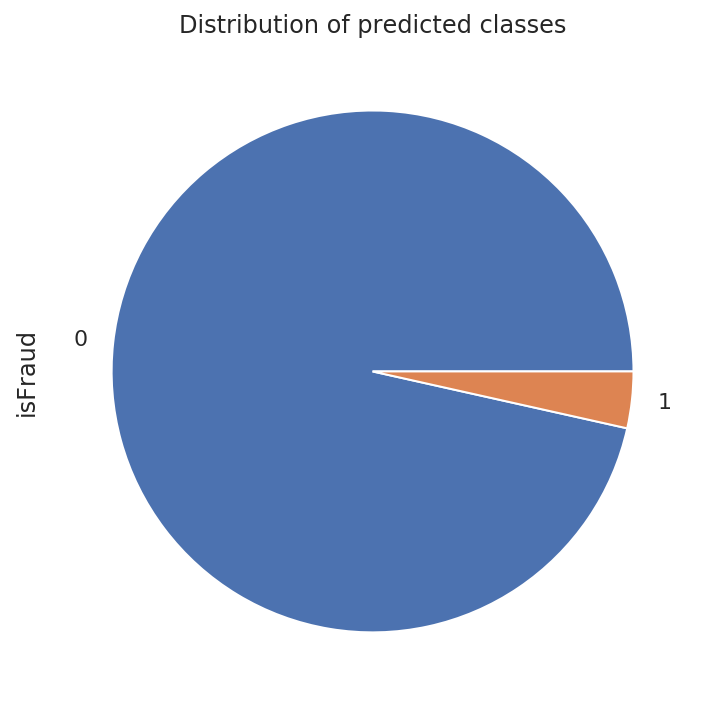

In [10]:
df.isFraud.value_counts().plot(kind='pie', title='Distribution of predicted classes');

In [11]:
df.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

As we can see, the classes are heavily imbalanced. Because of that, oversampling or undersampling has to be done to avoid classifier being overfitted to major class.

### Missing values

To know which attributes can be helpful in our prediction, let's check how many values are missing in each attribute.

**Note:** Plots below are showing fraction of the data that are **not** missing (column with value 1 has no missing values).

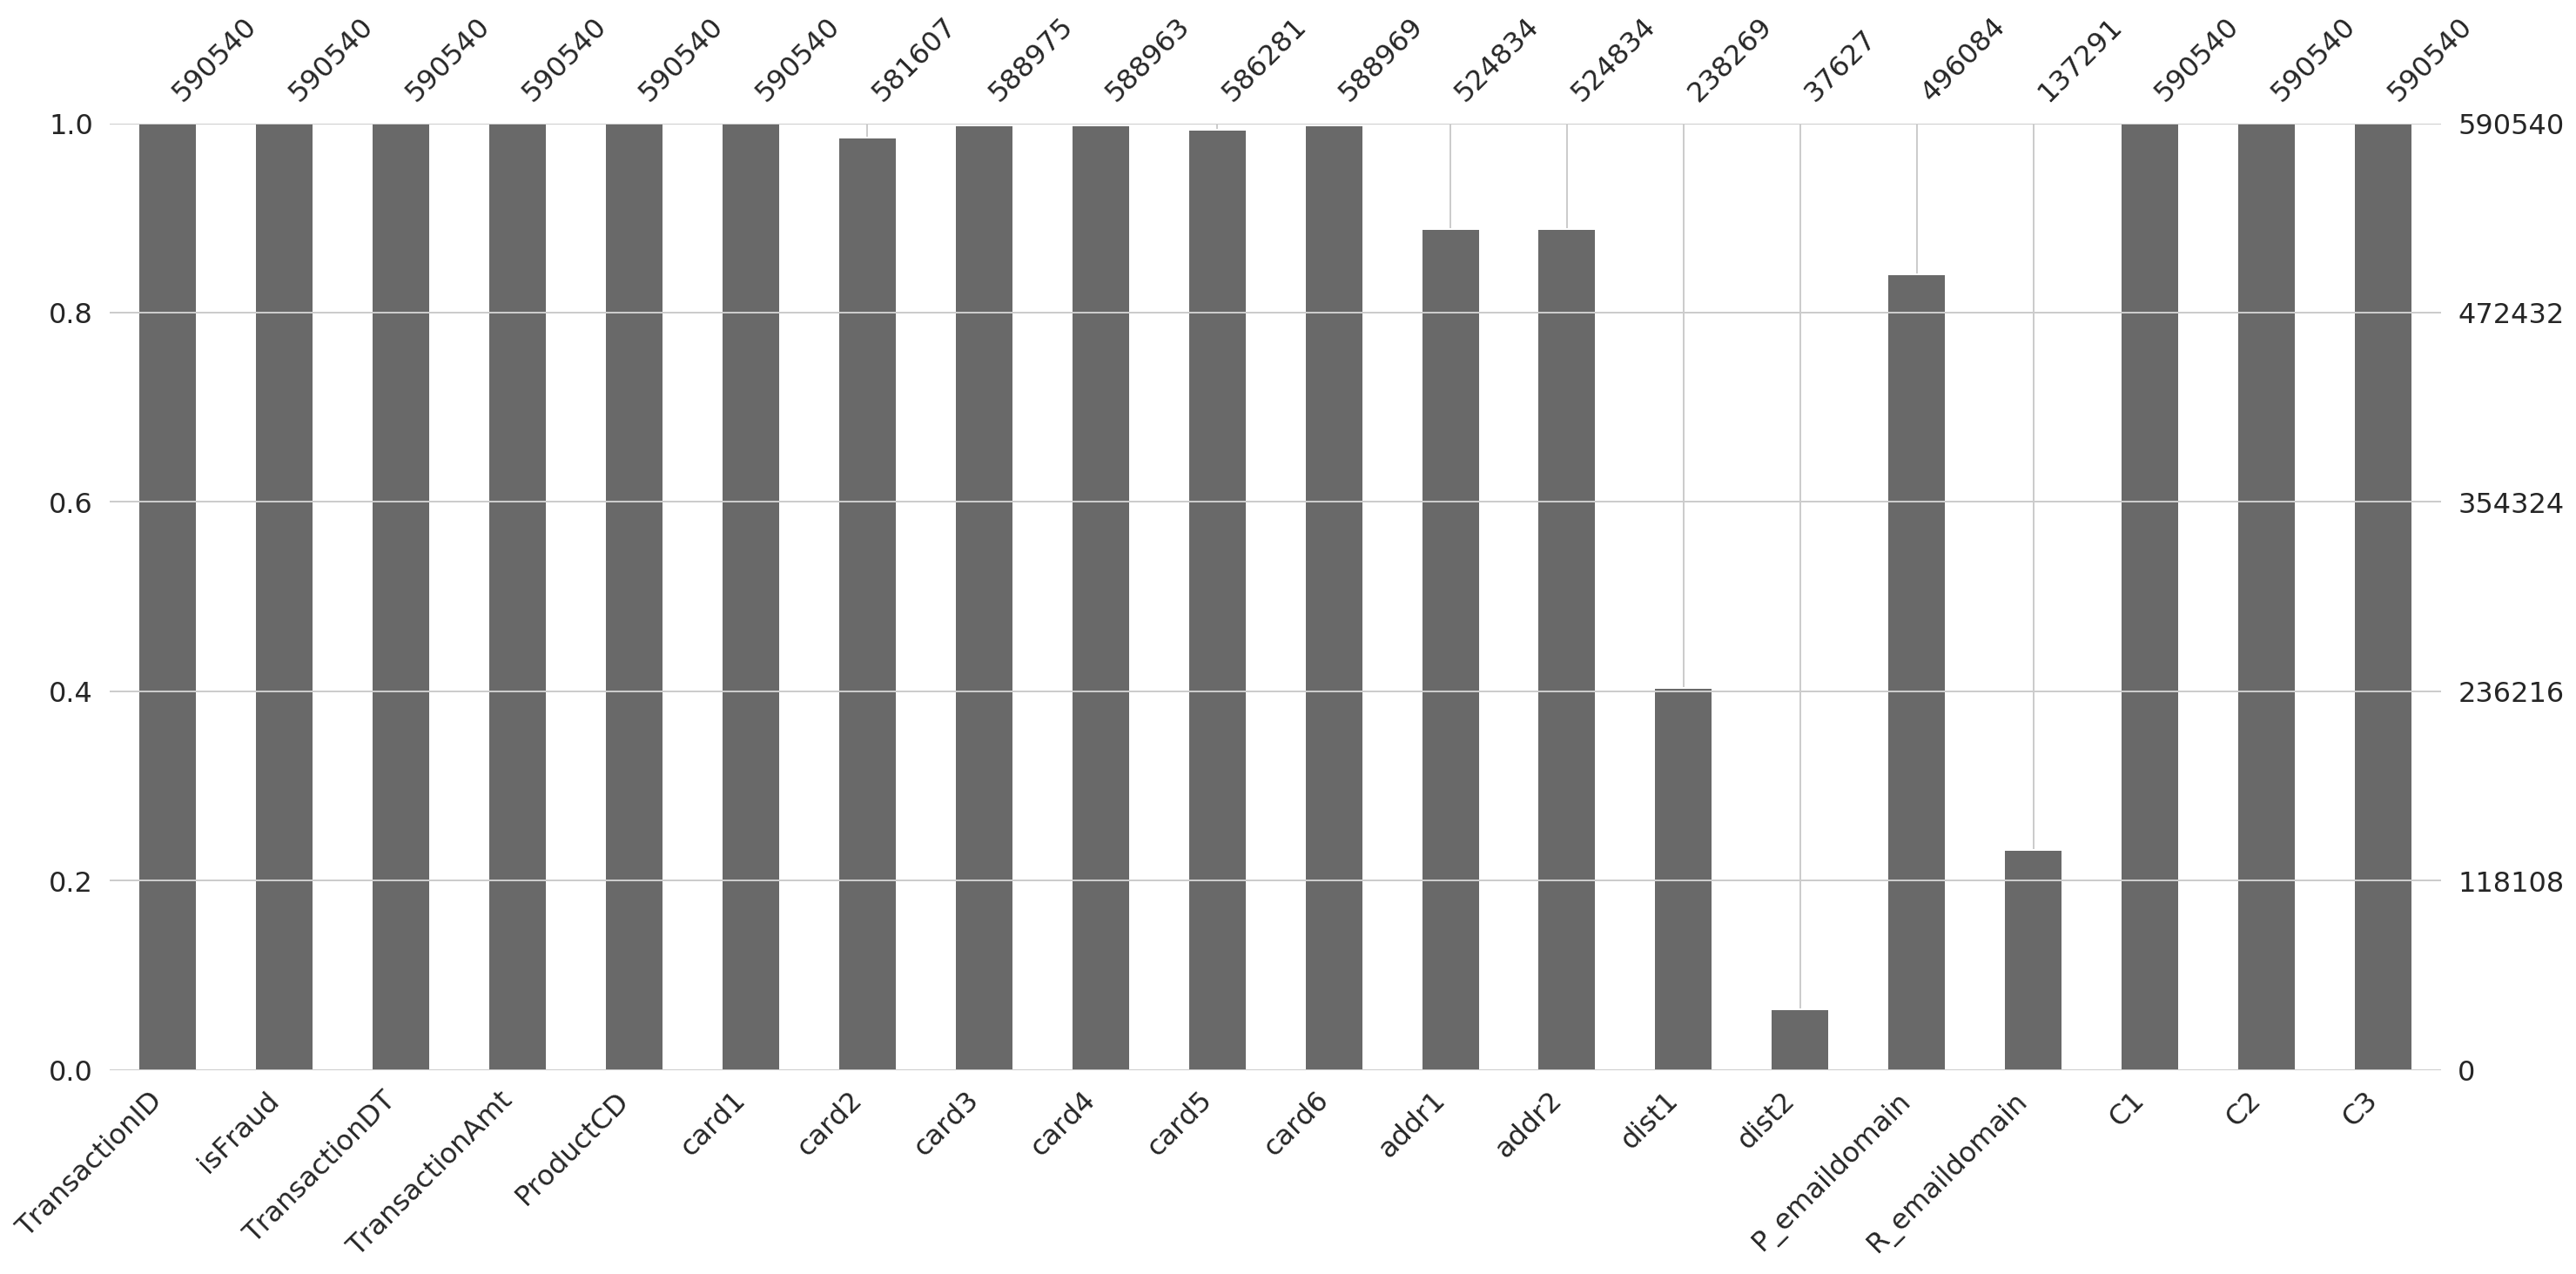

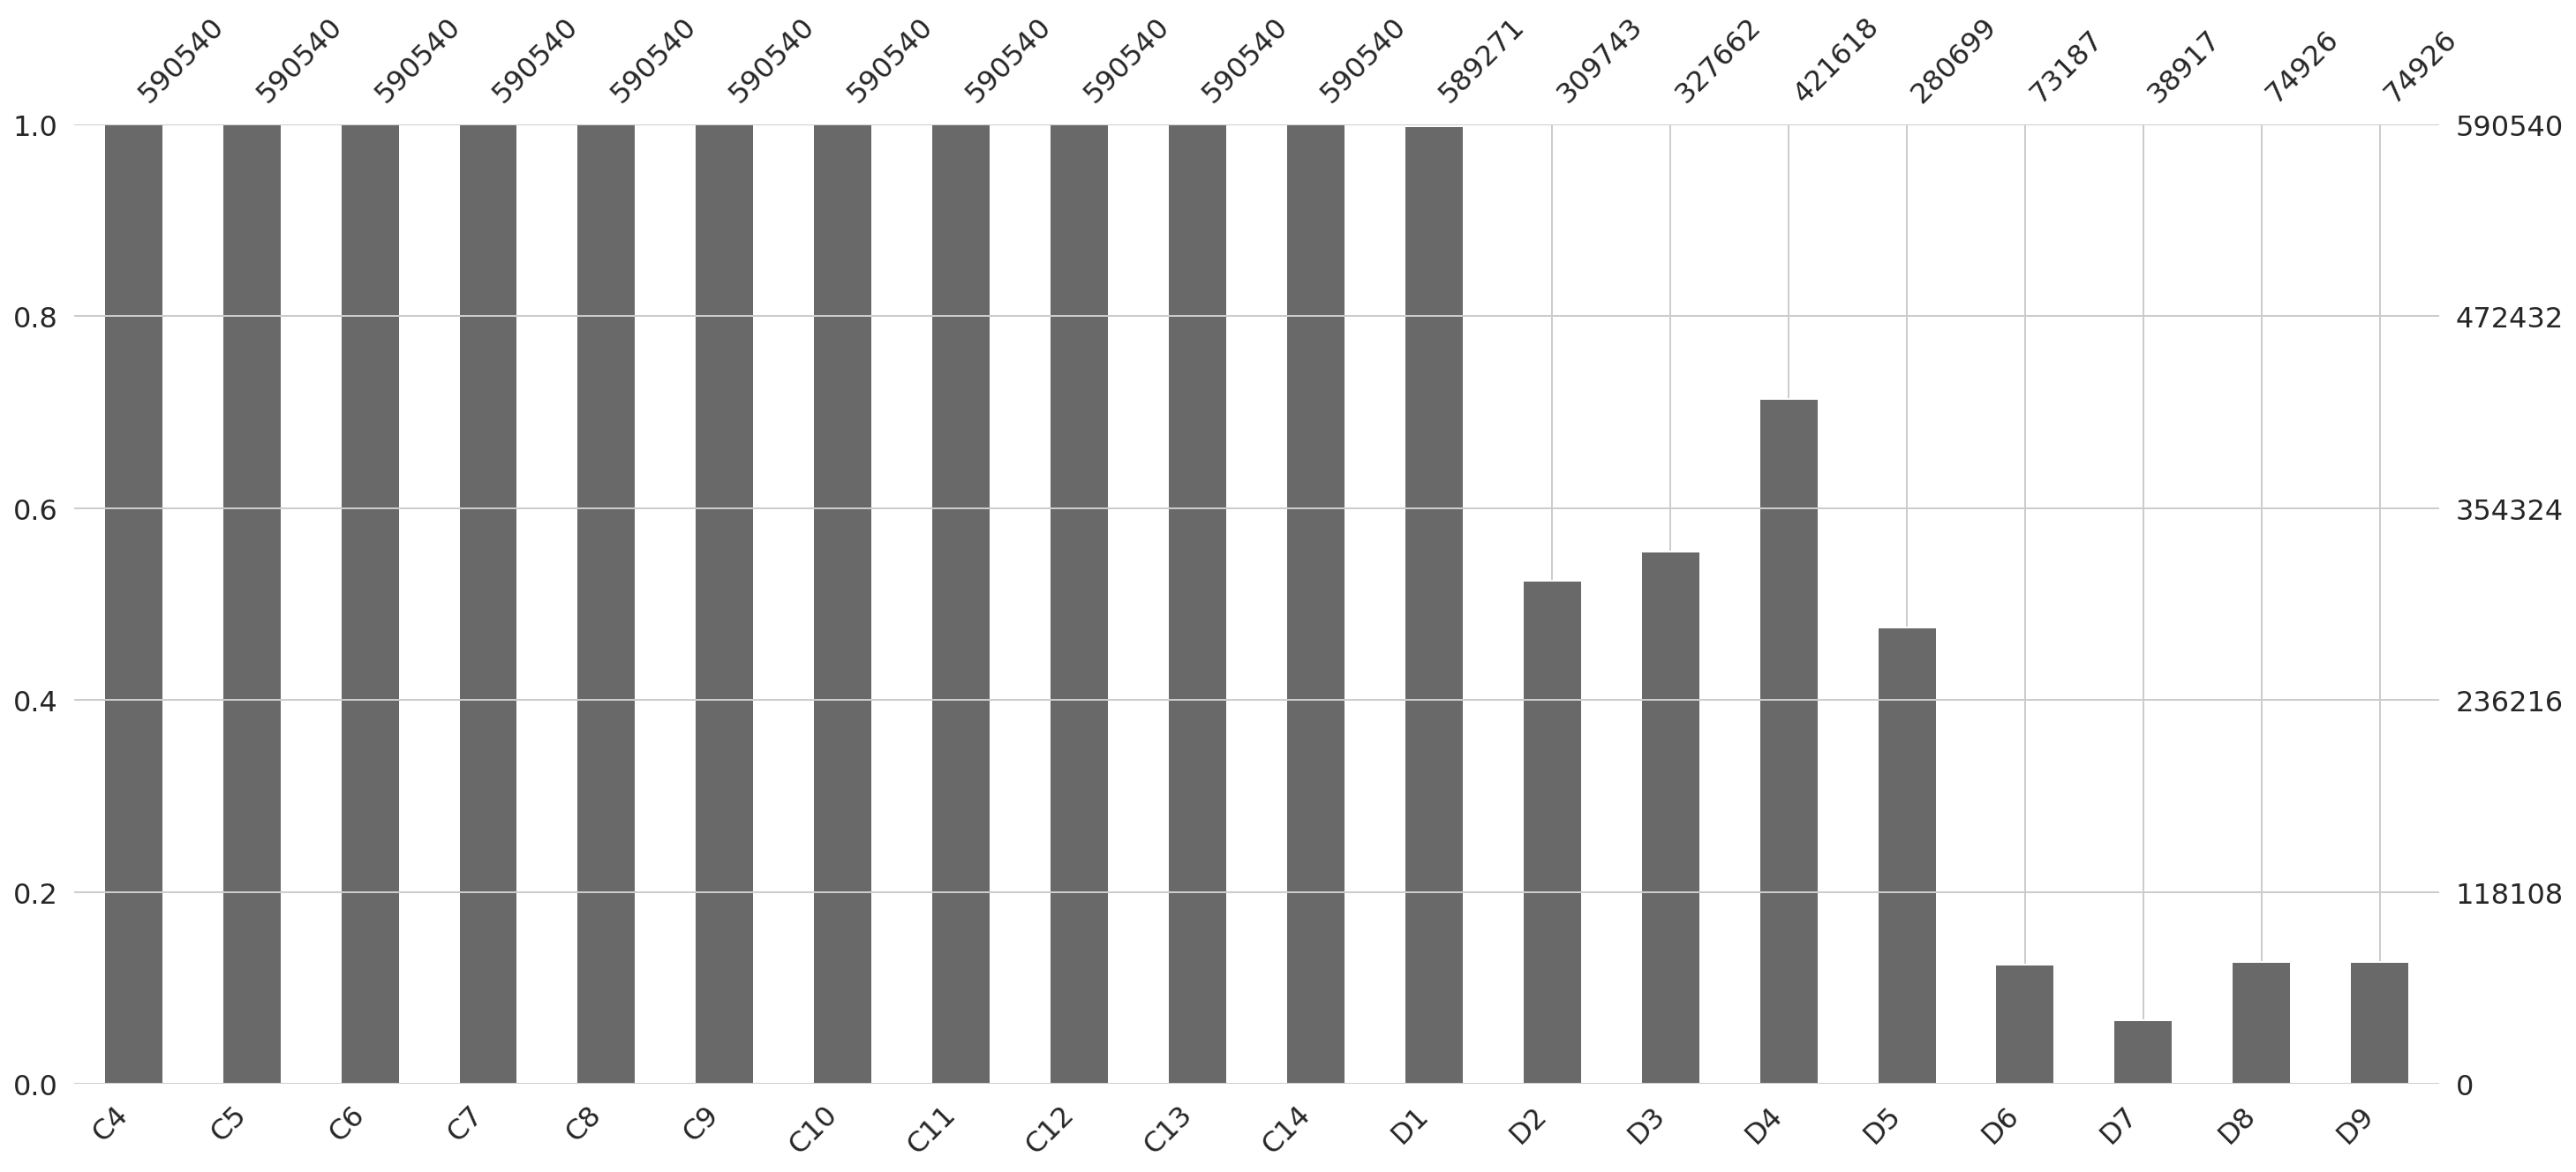

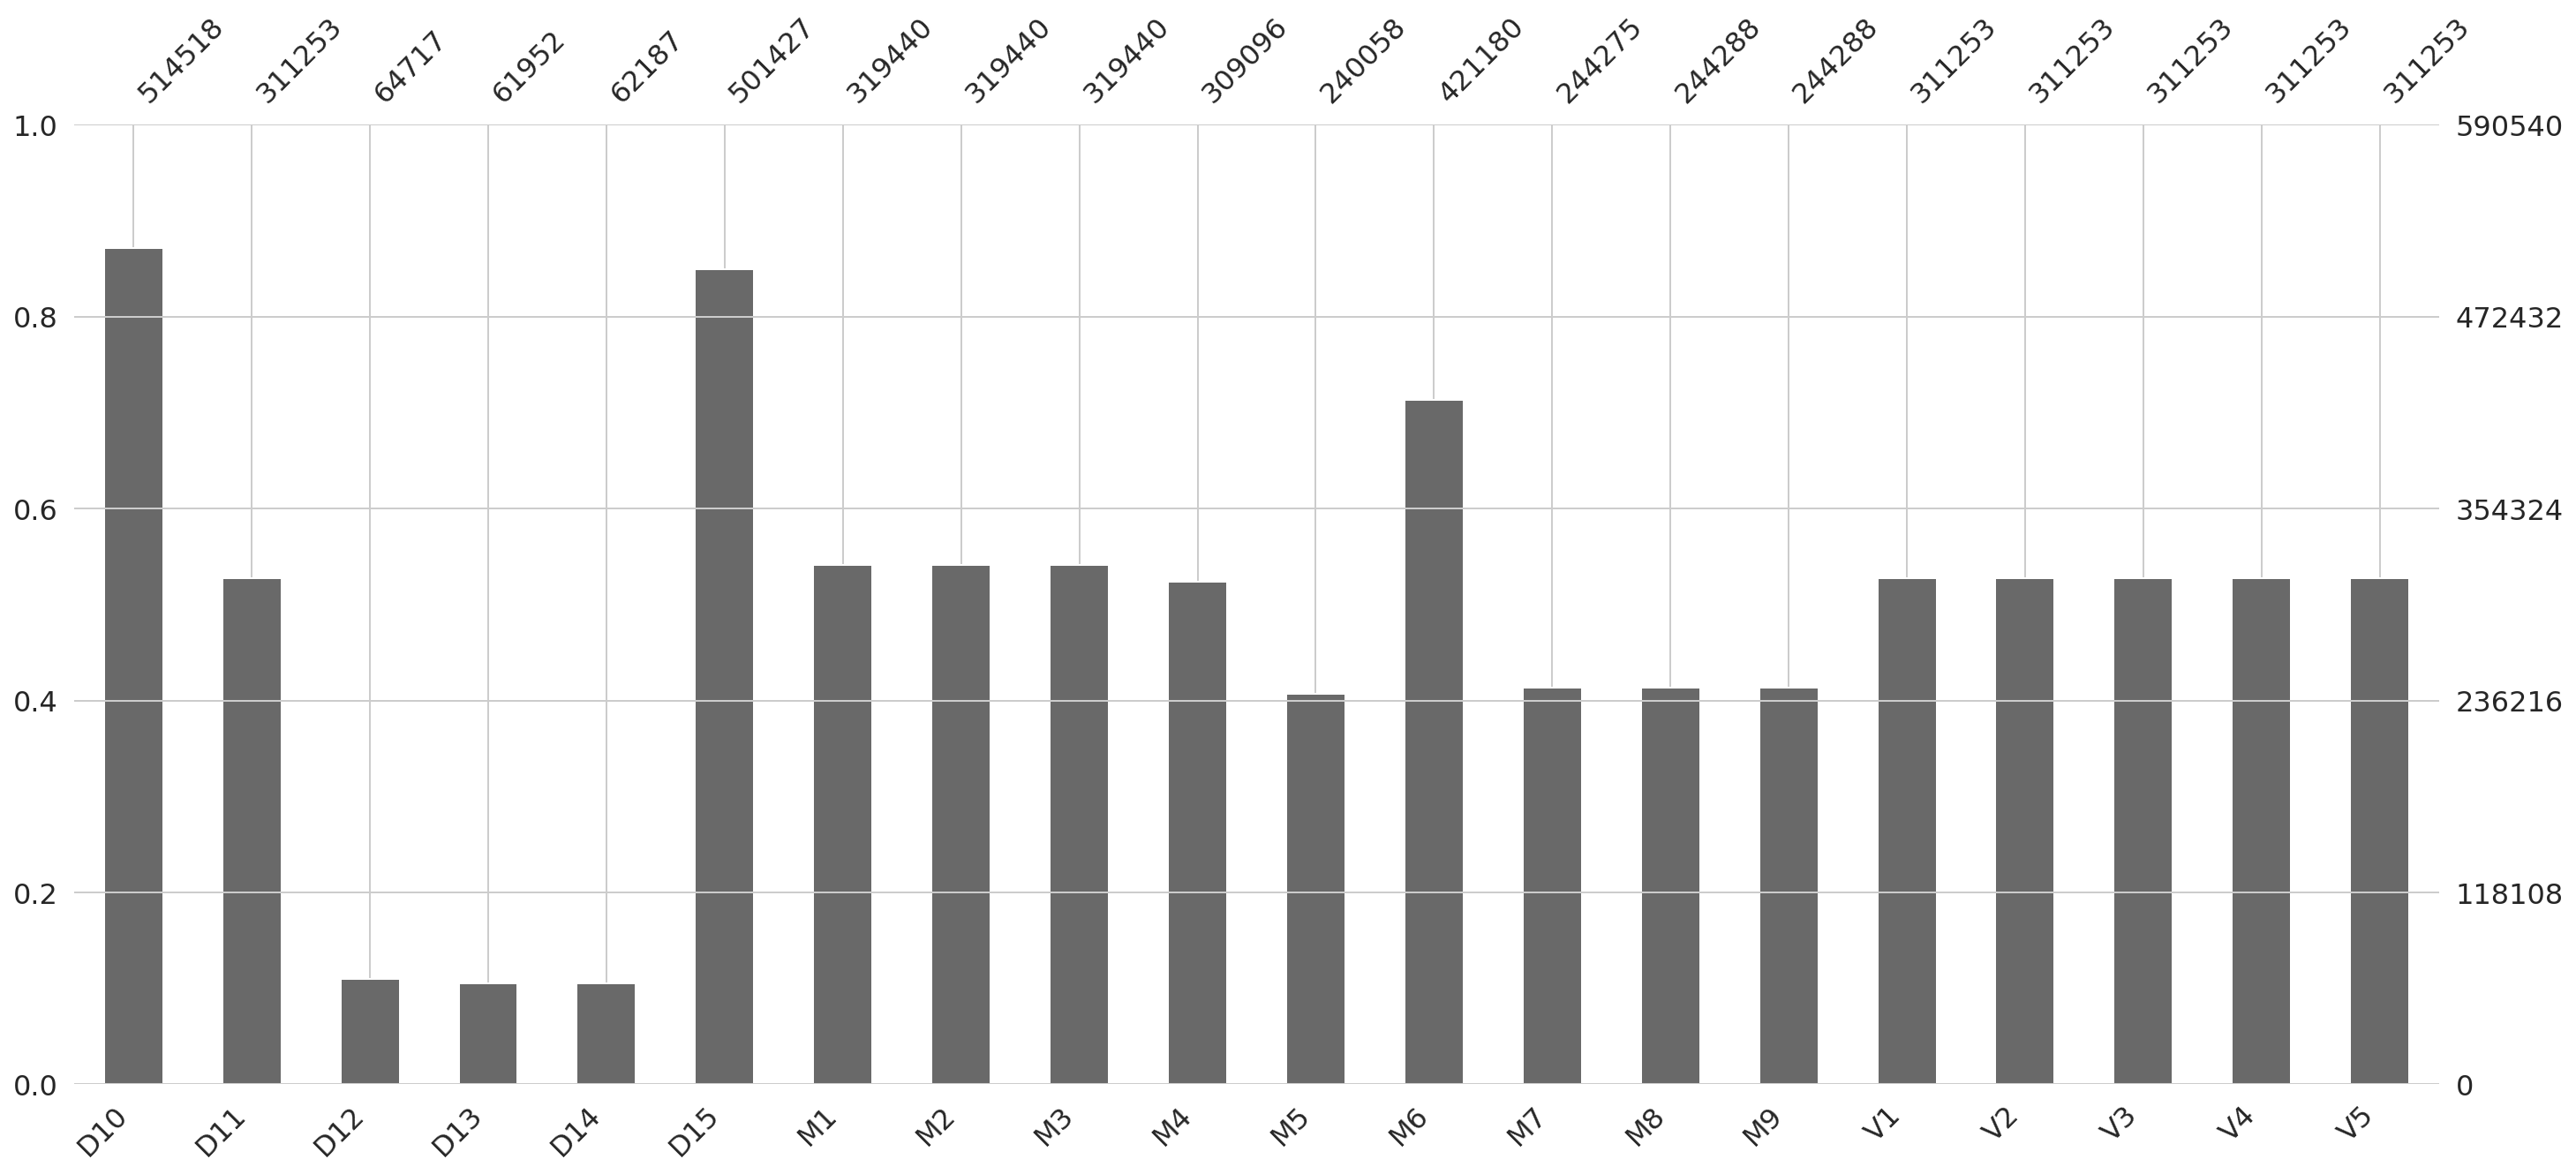

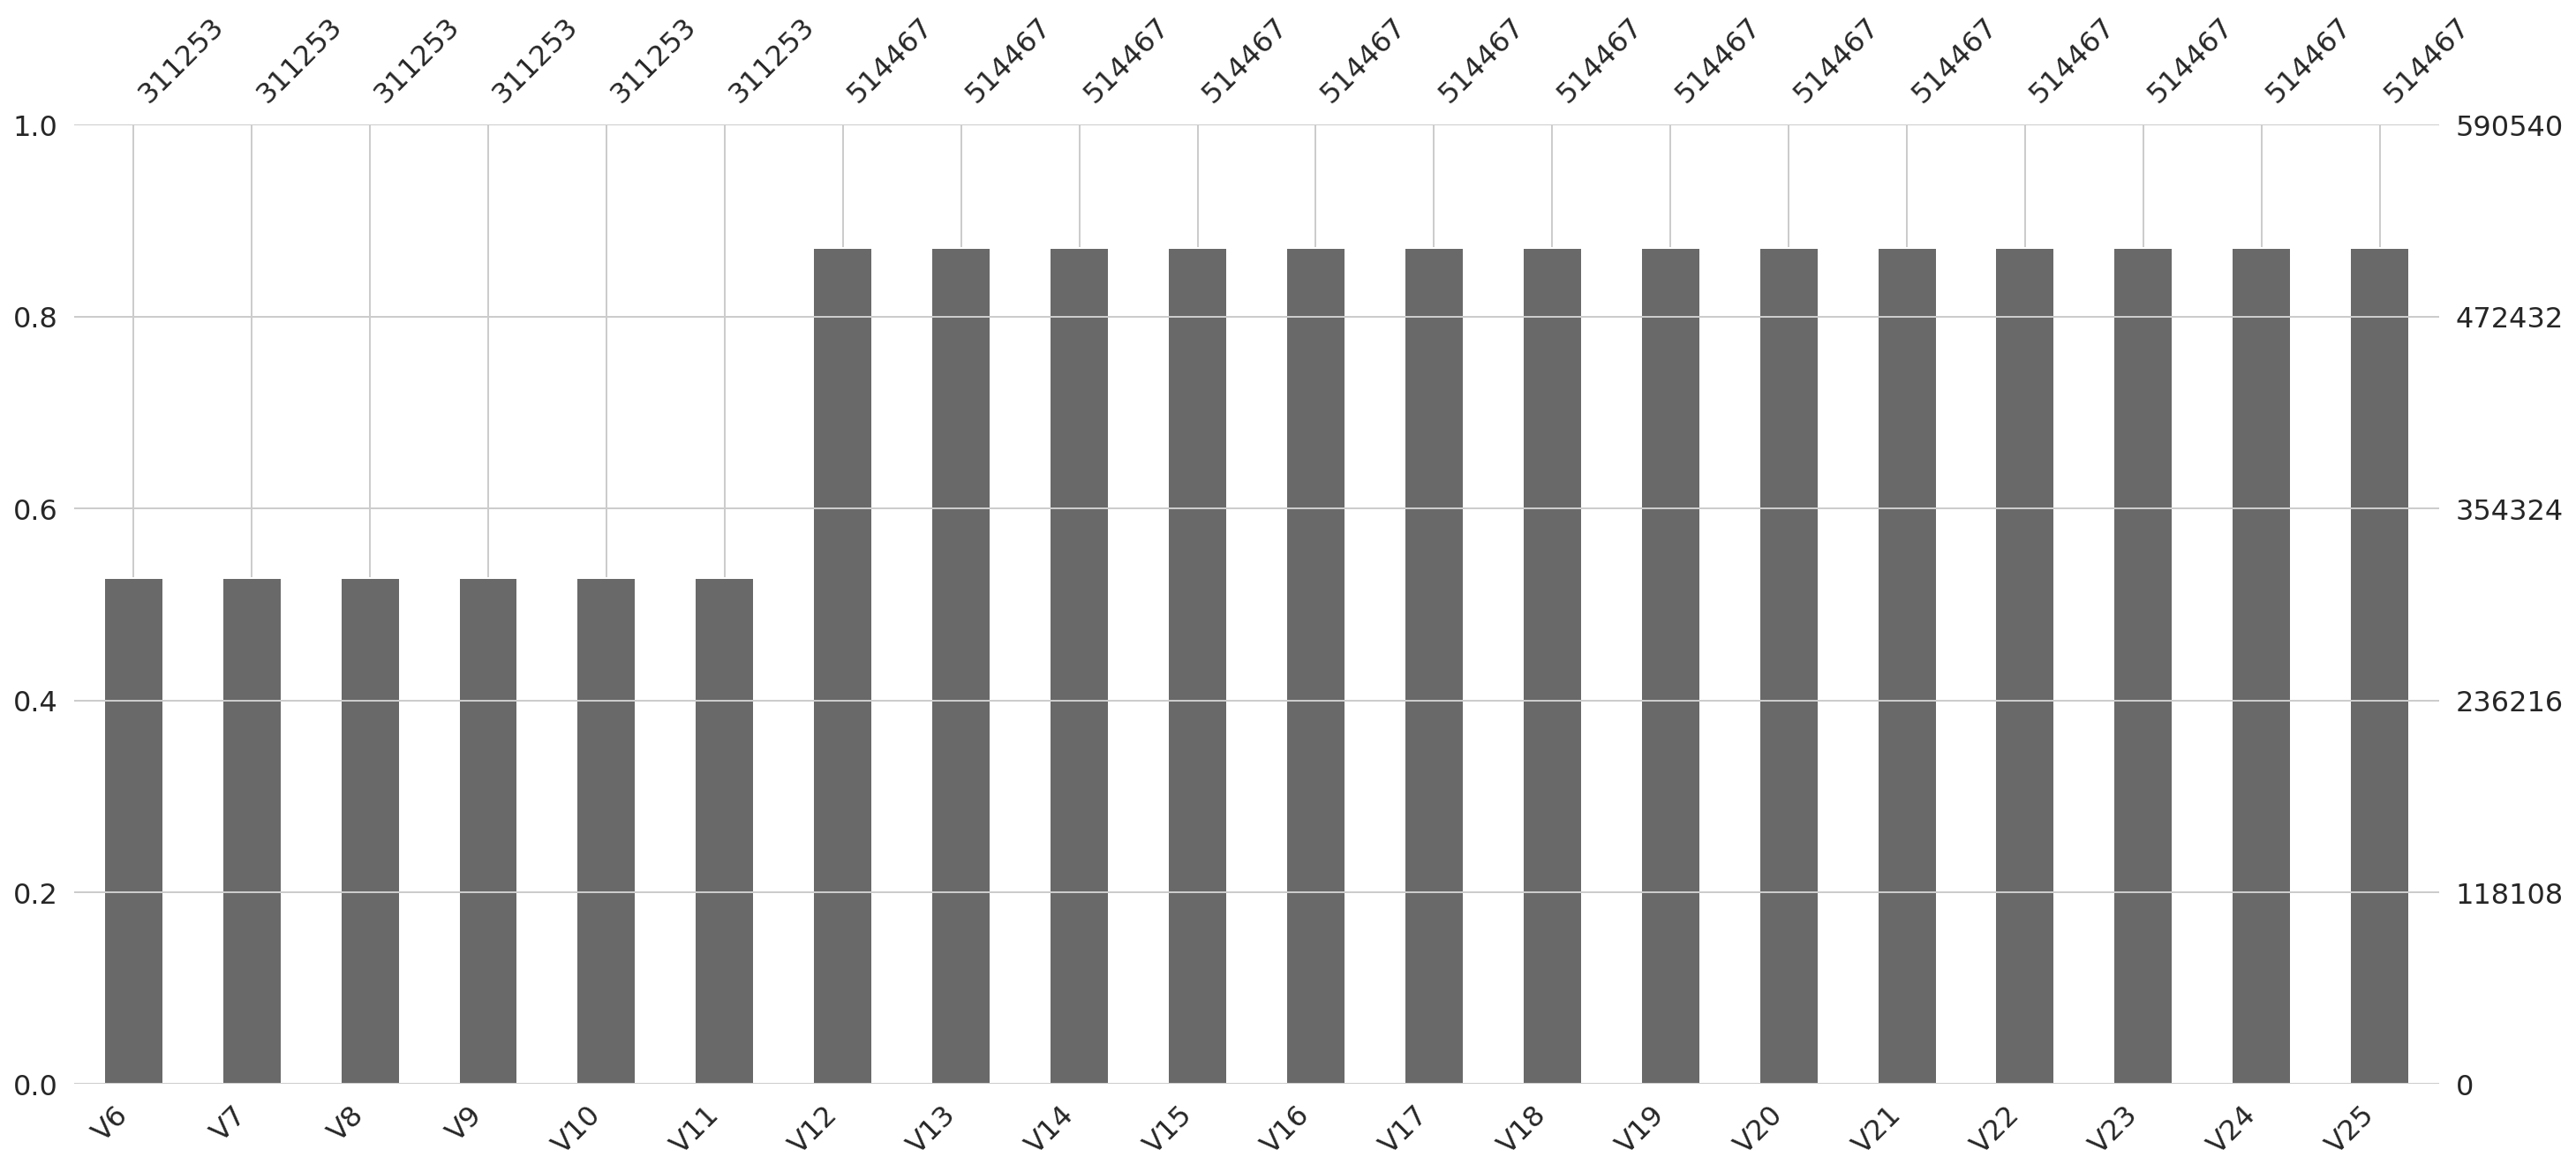

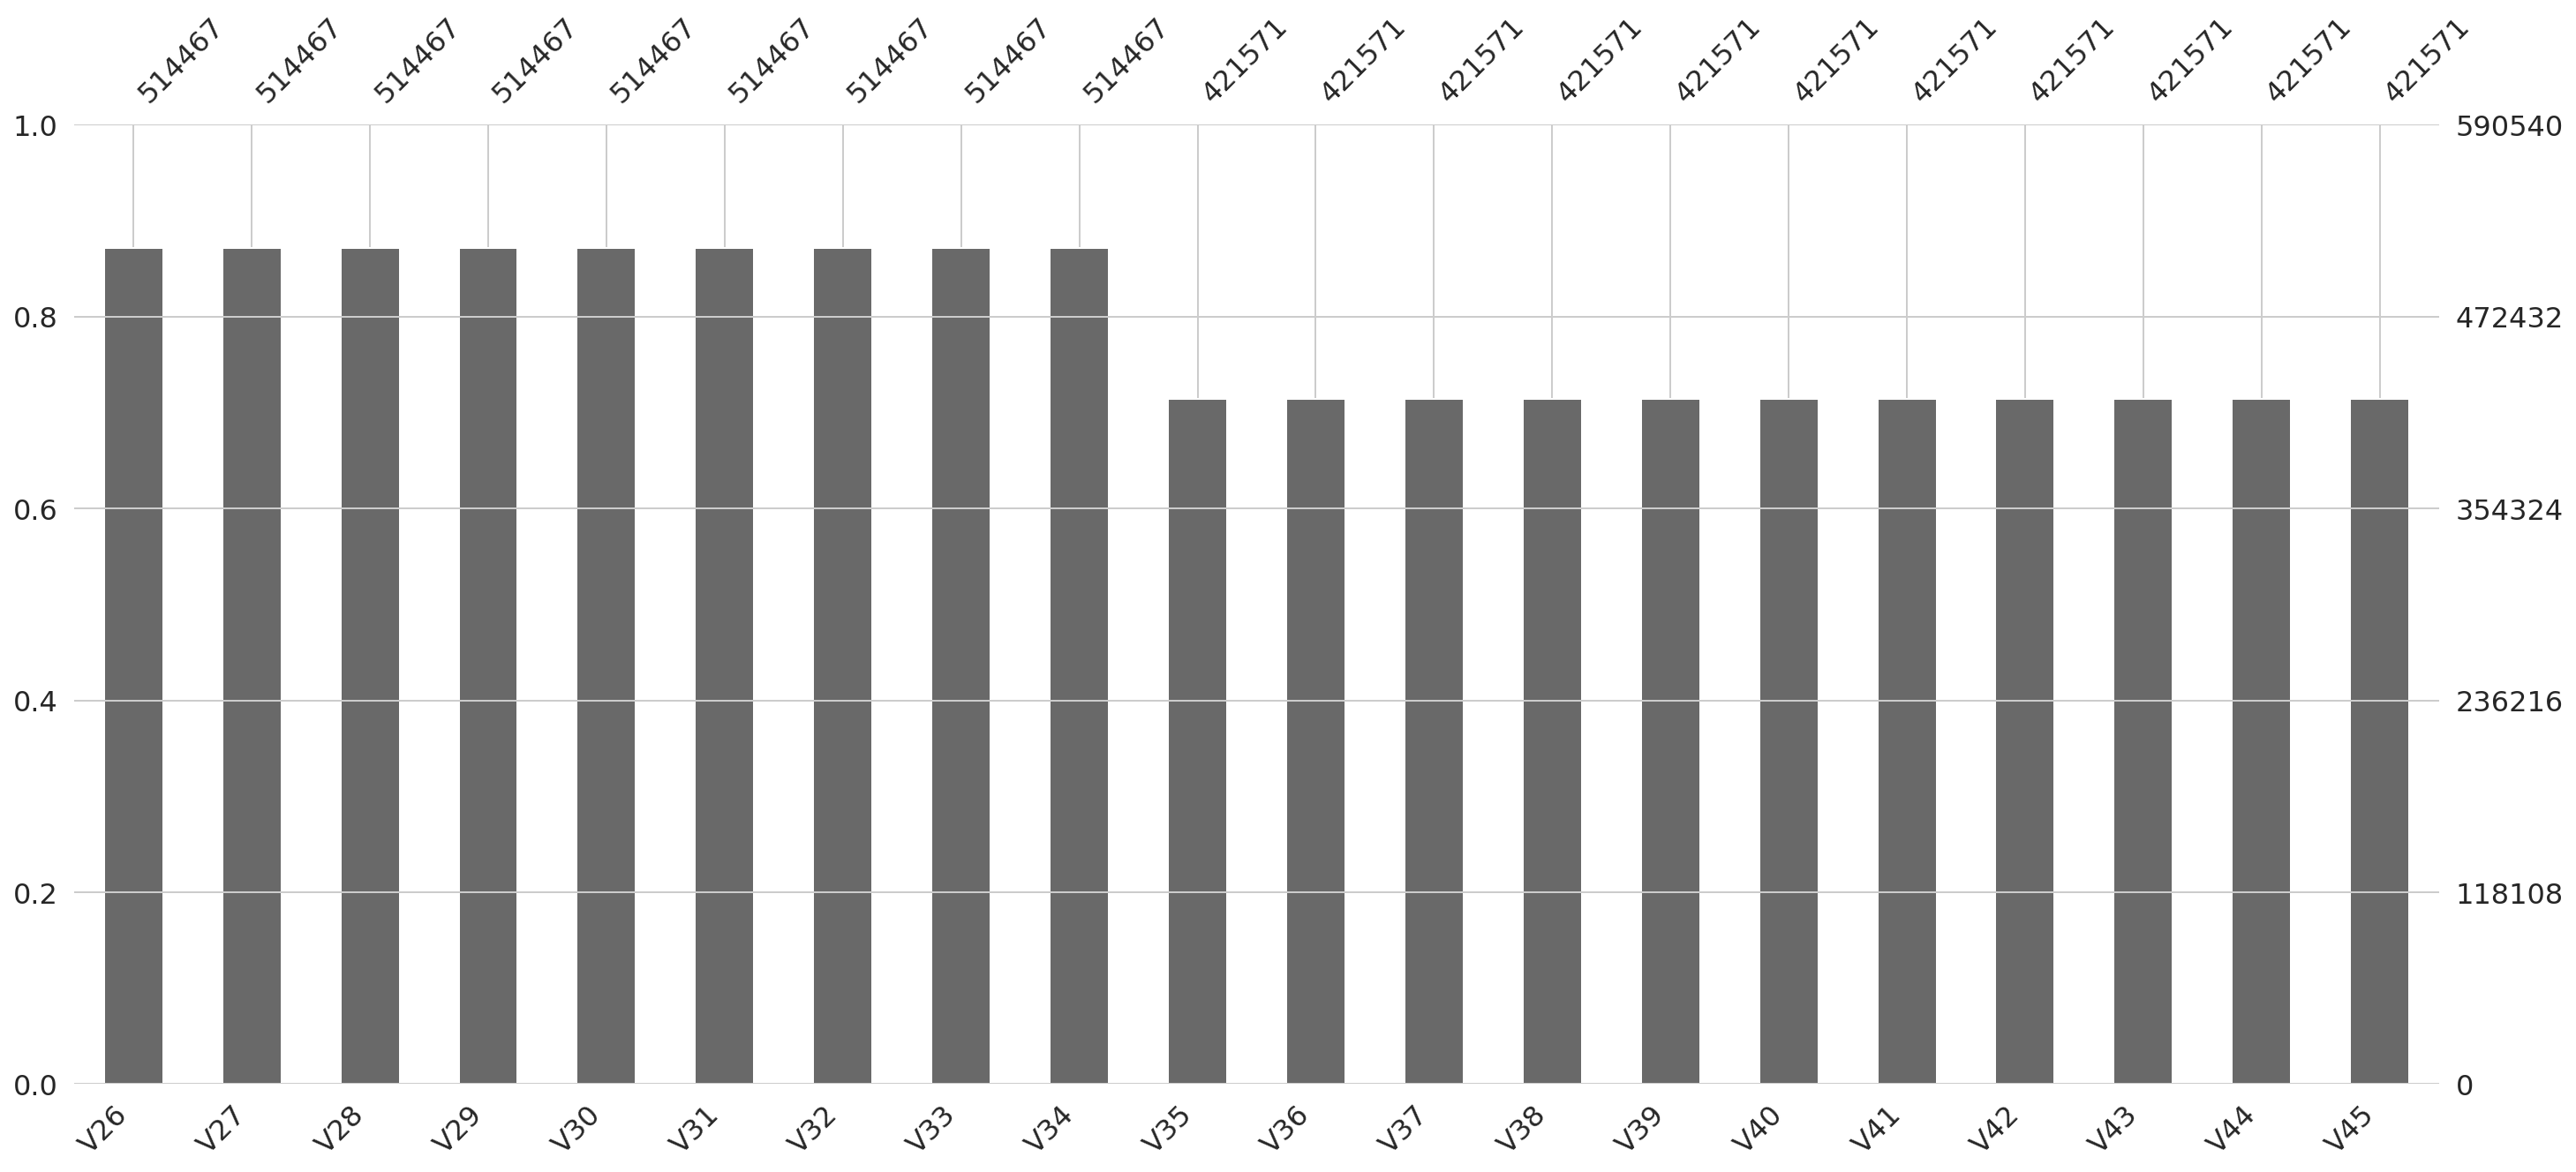

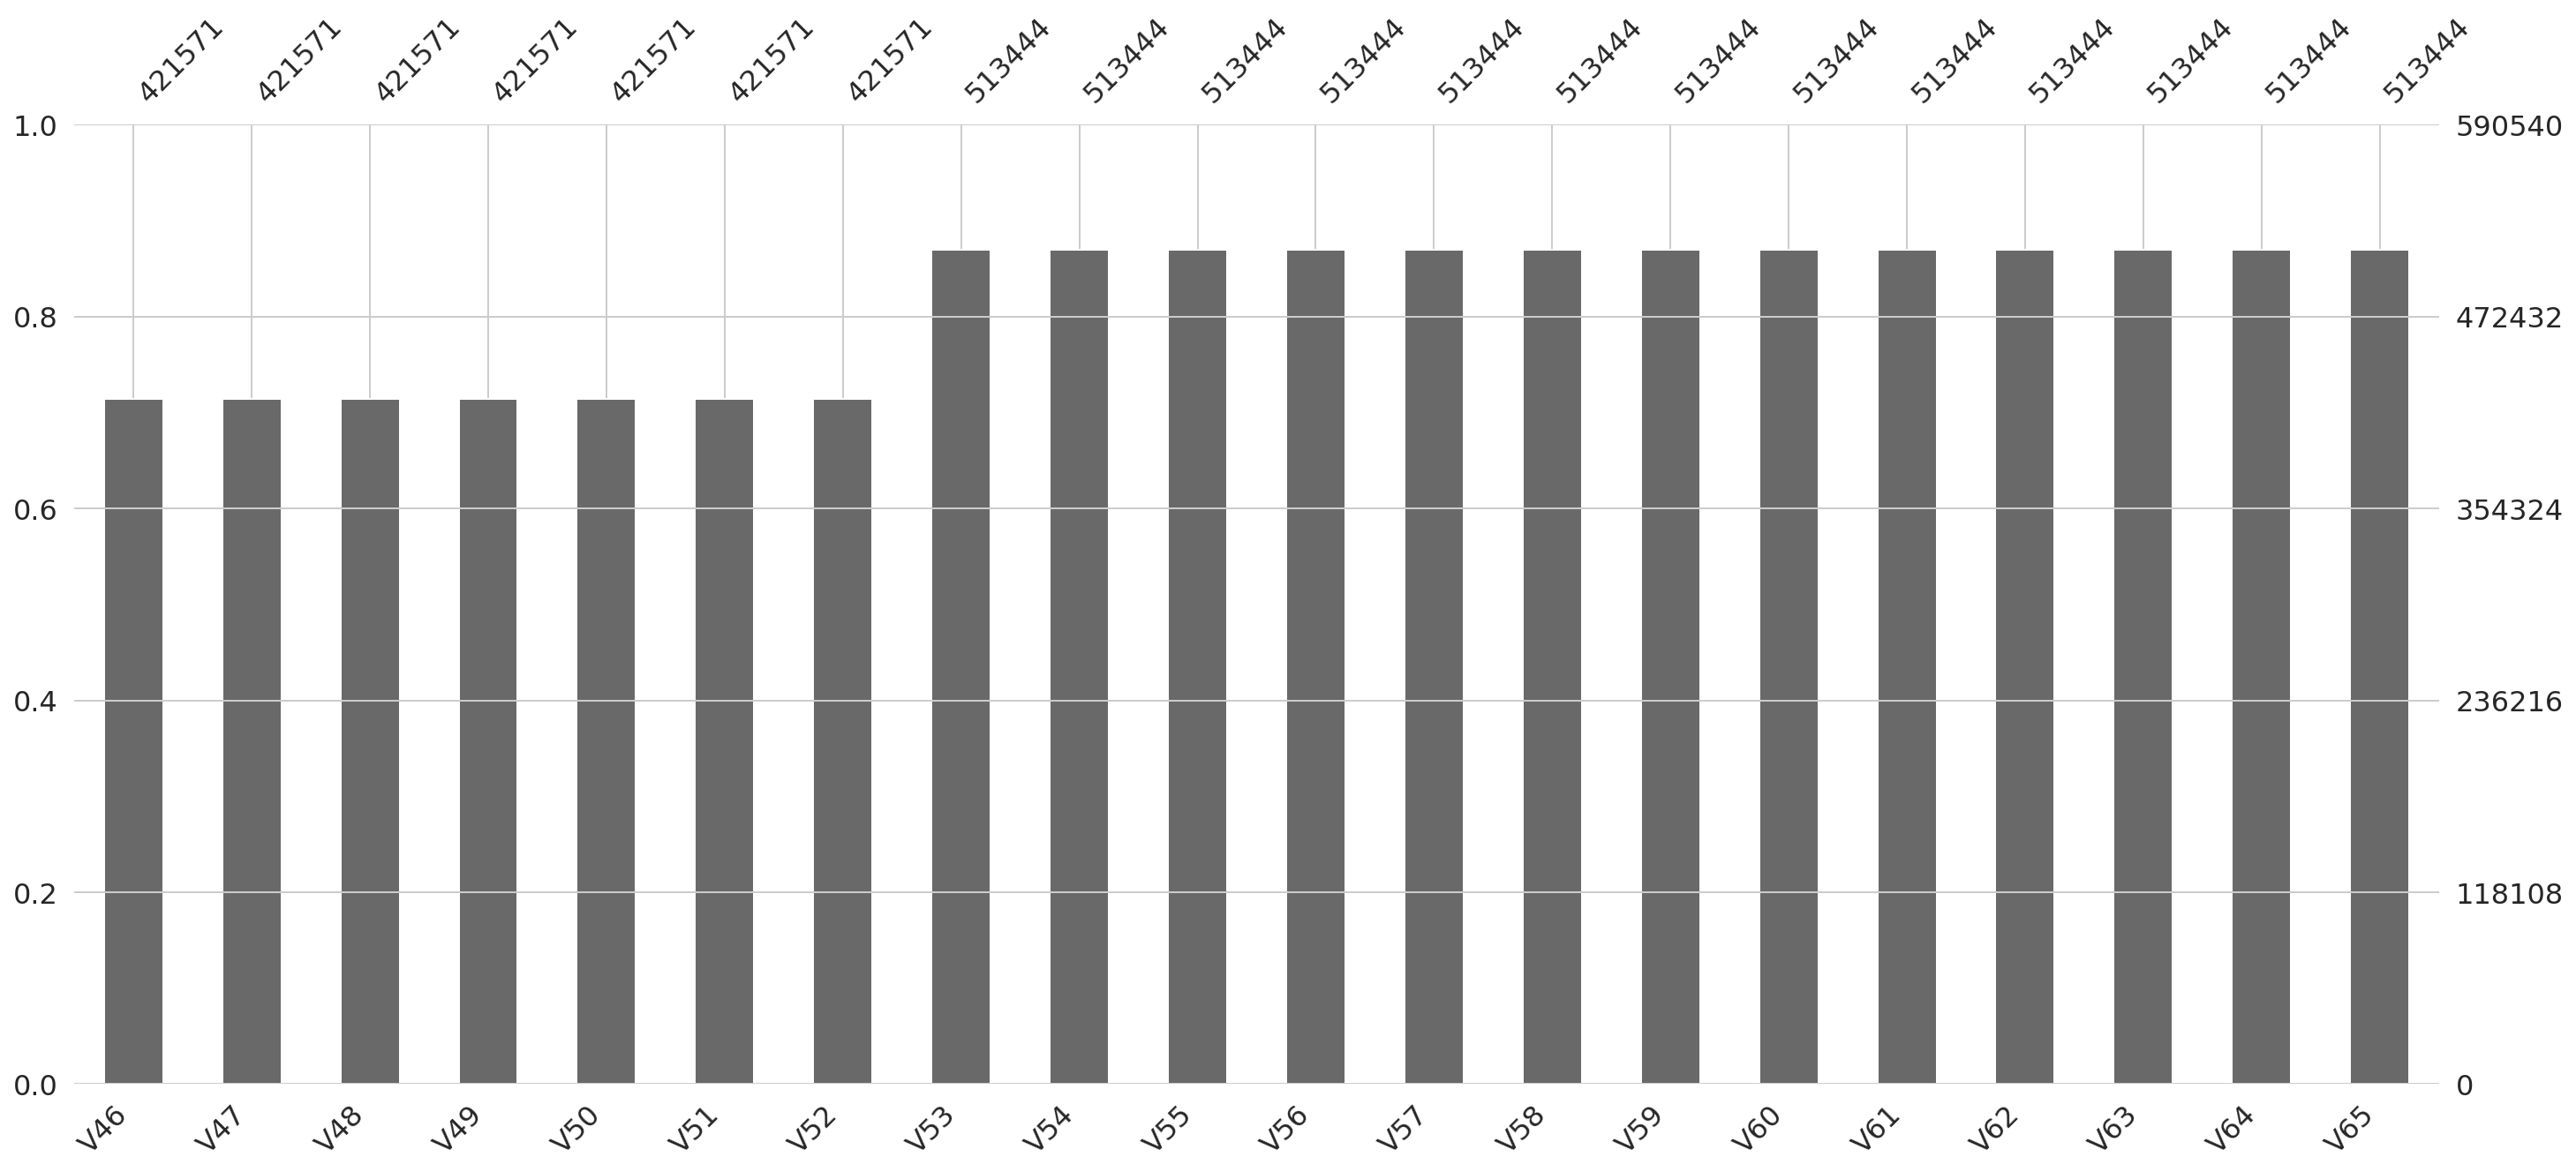

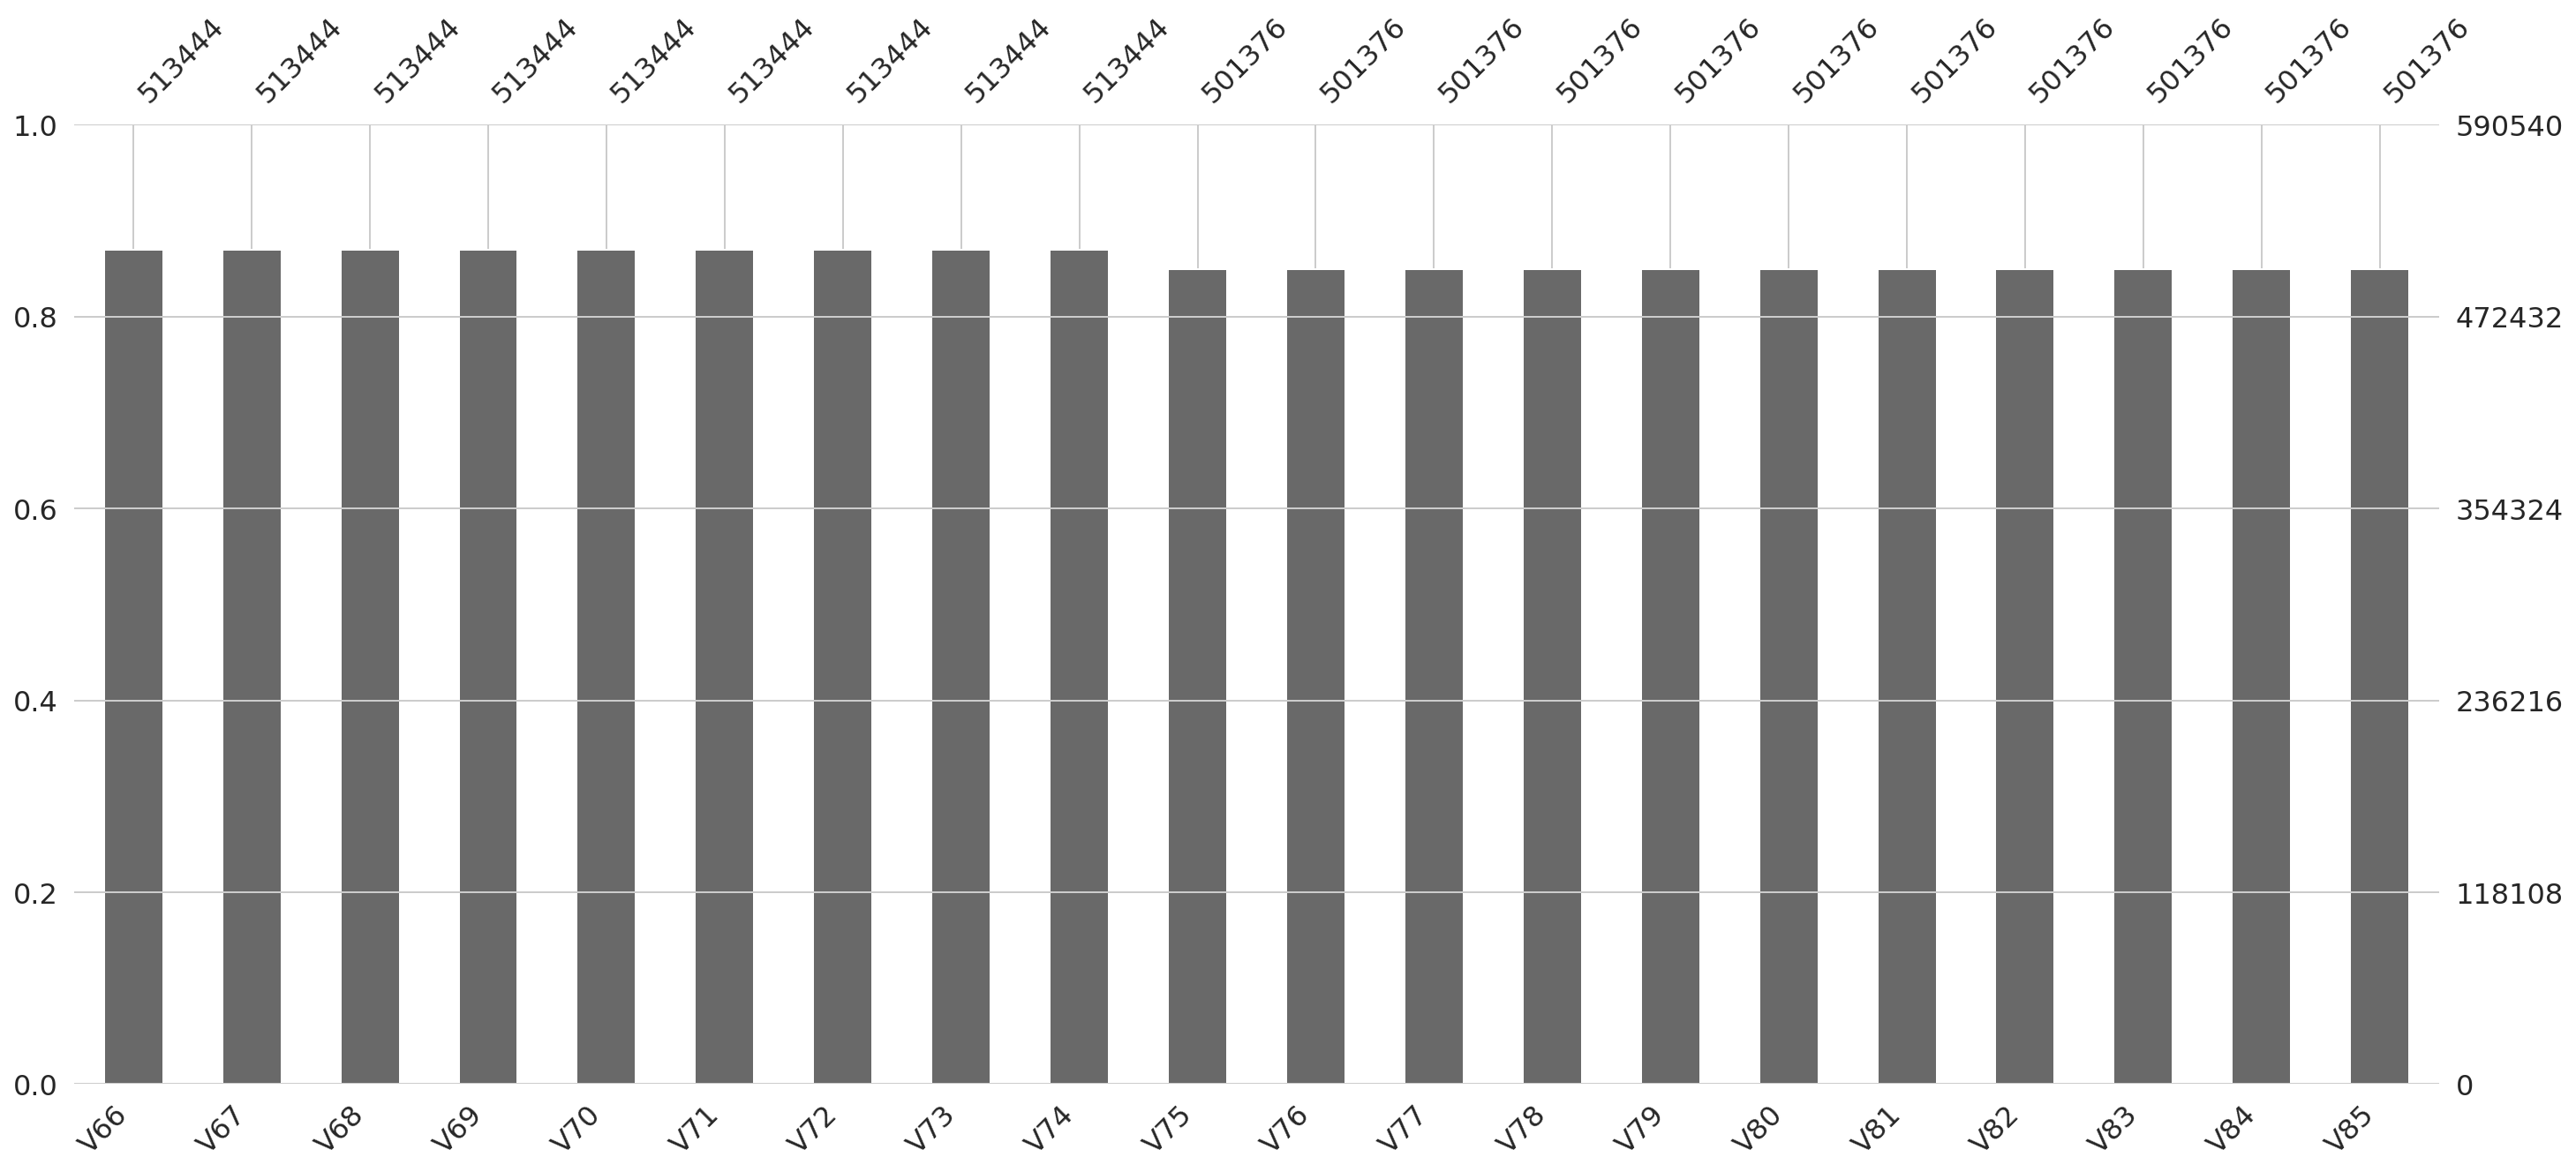

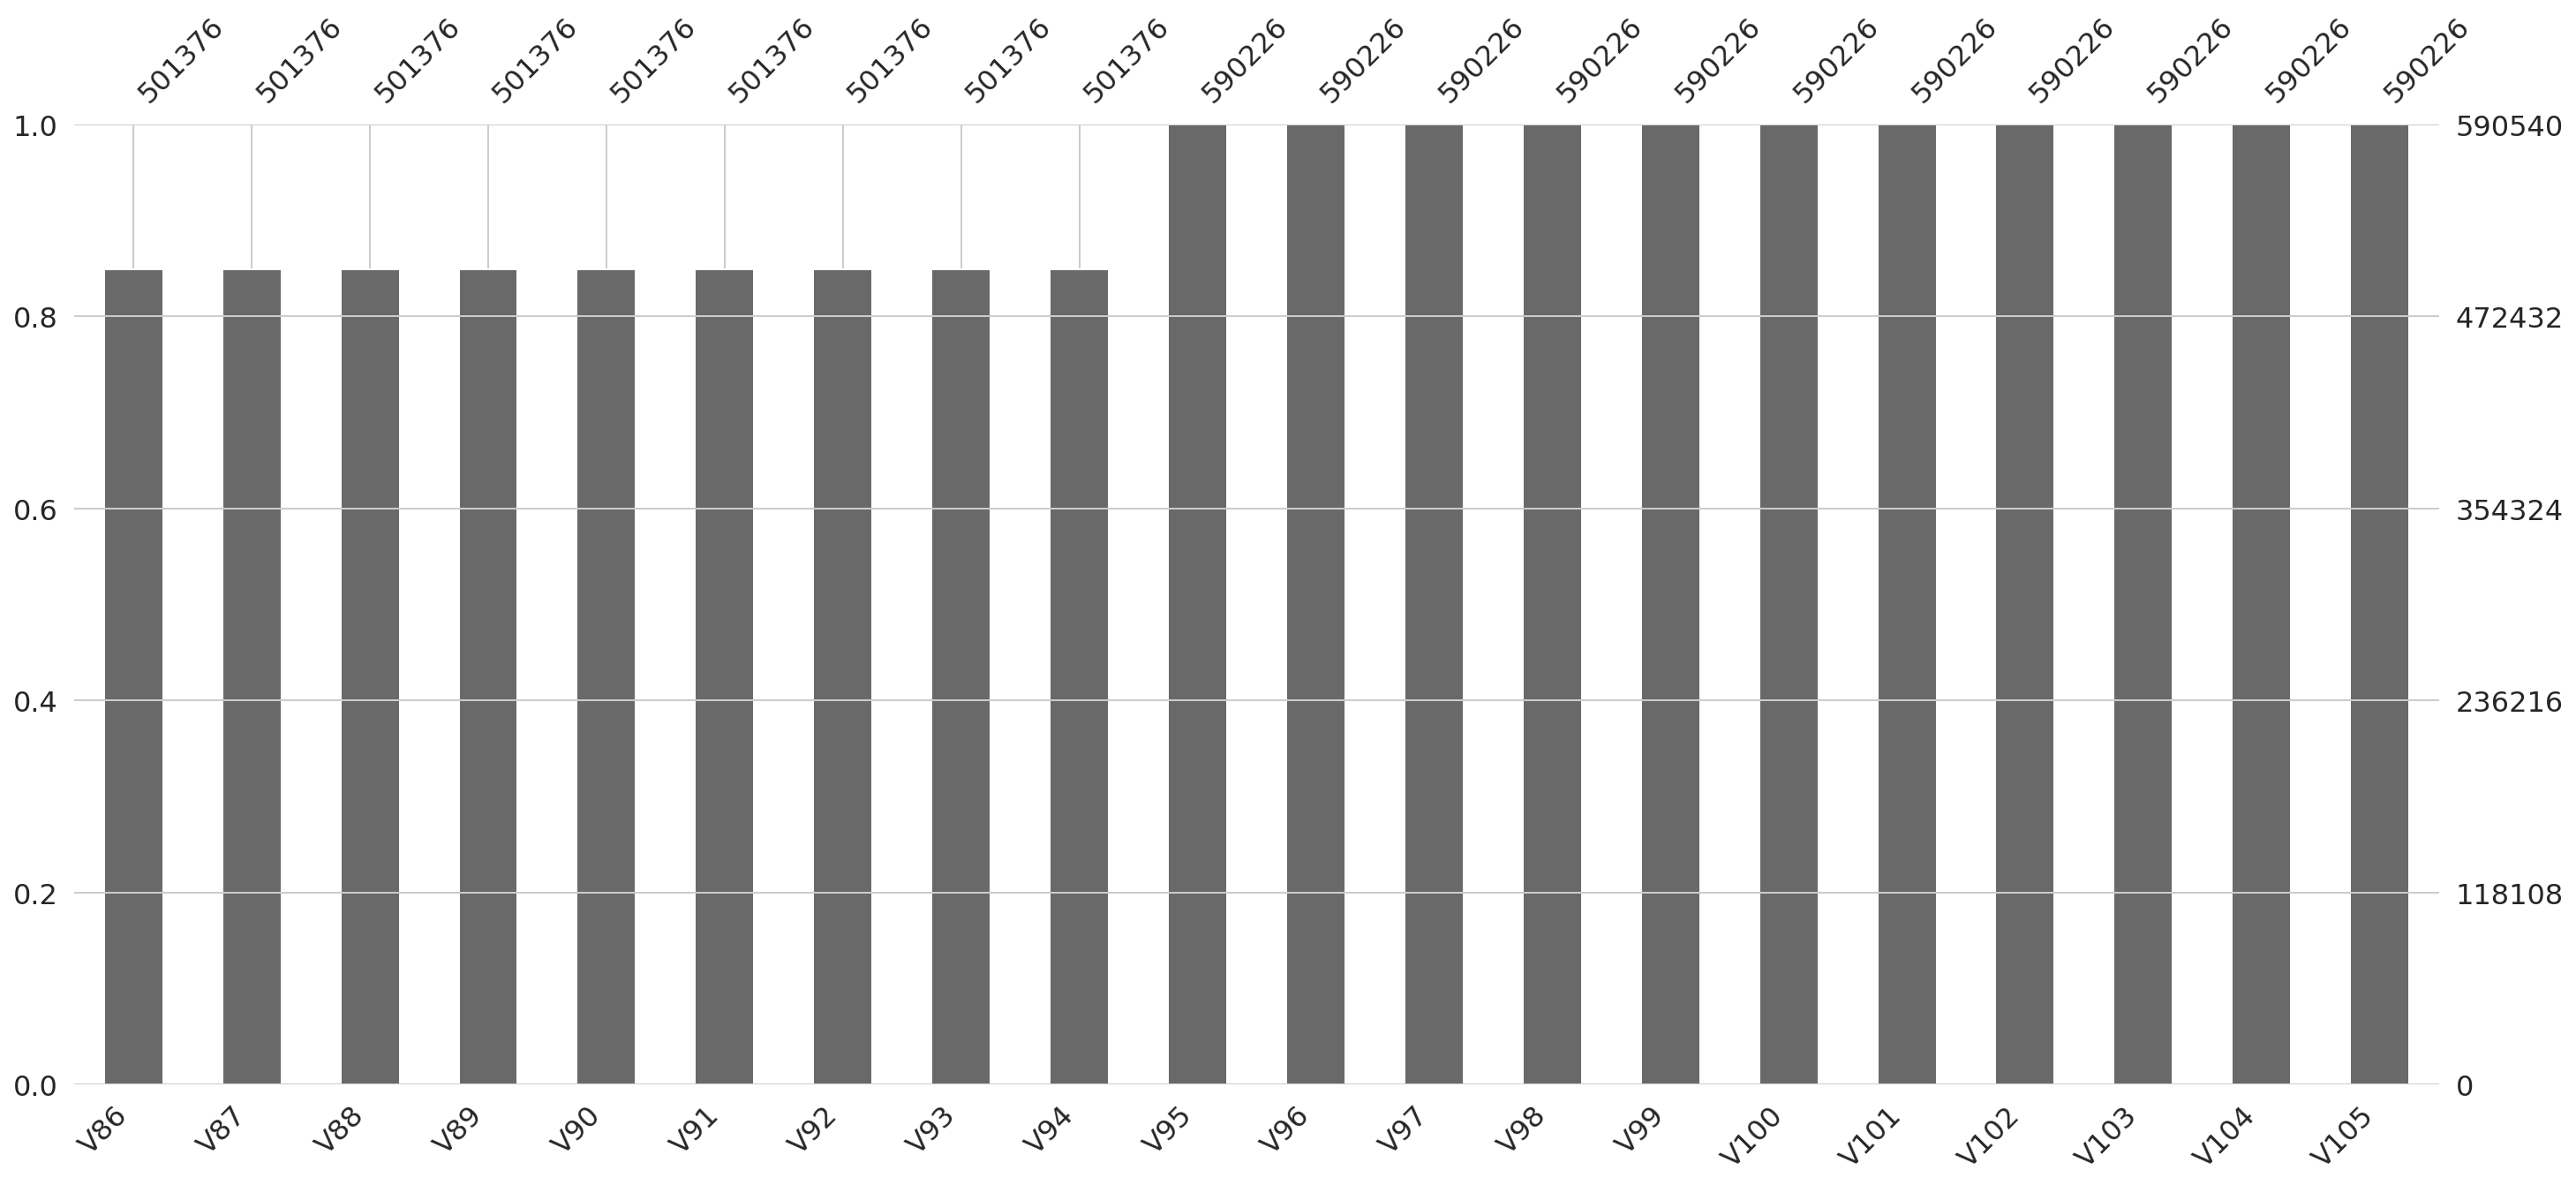

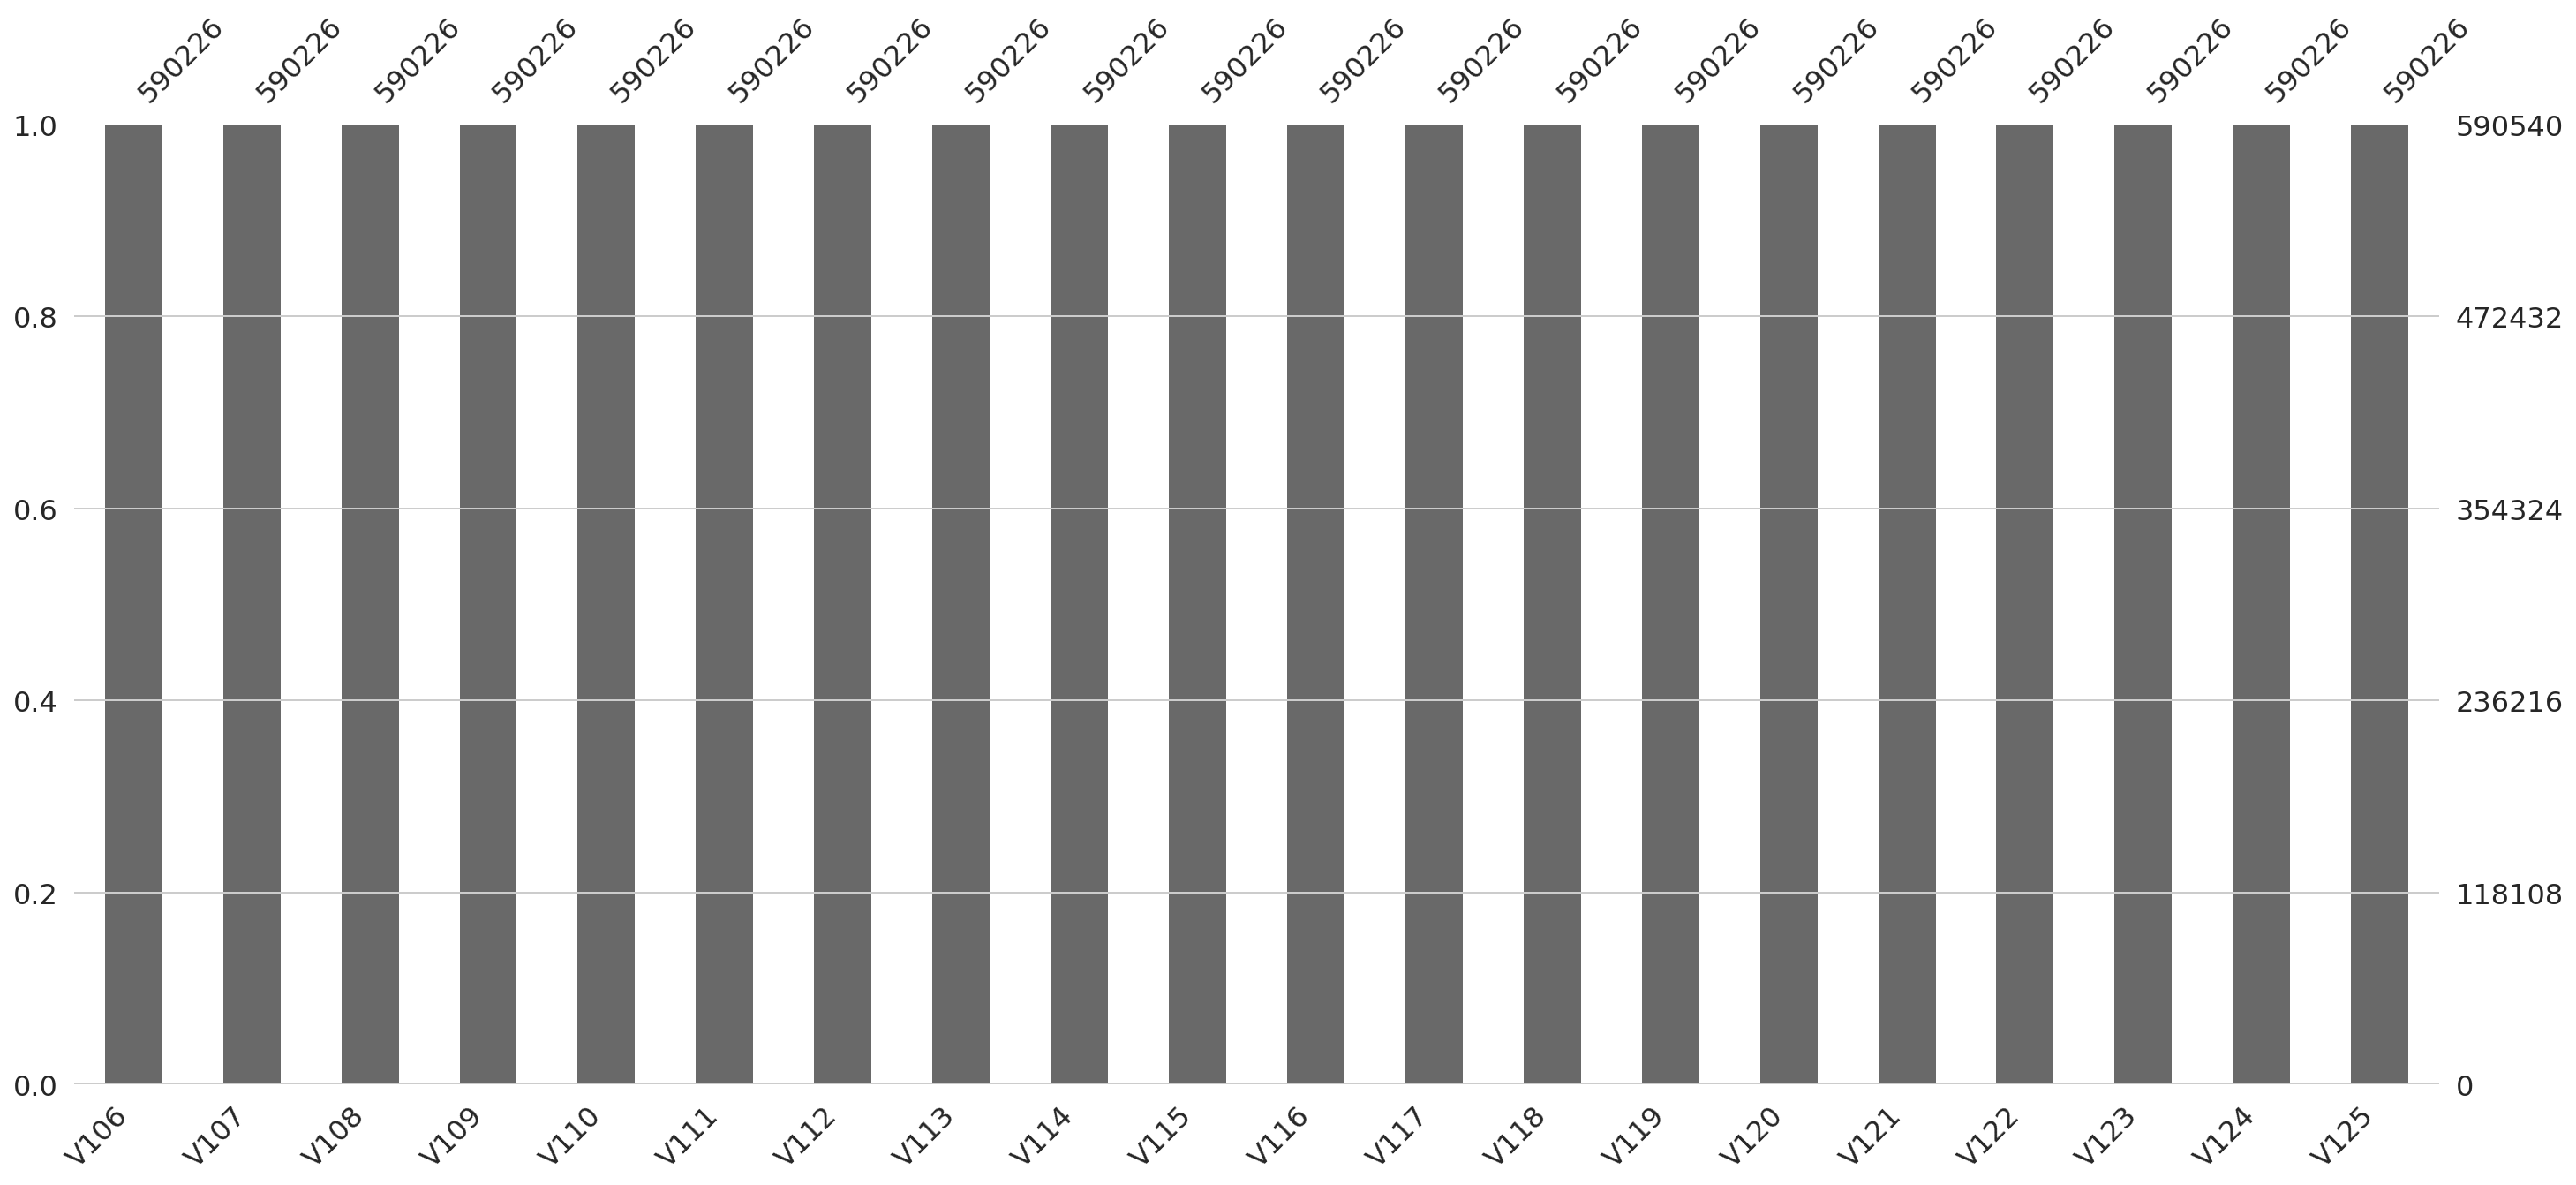

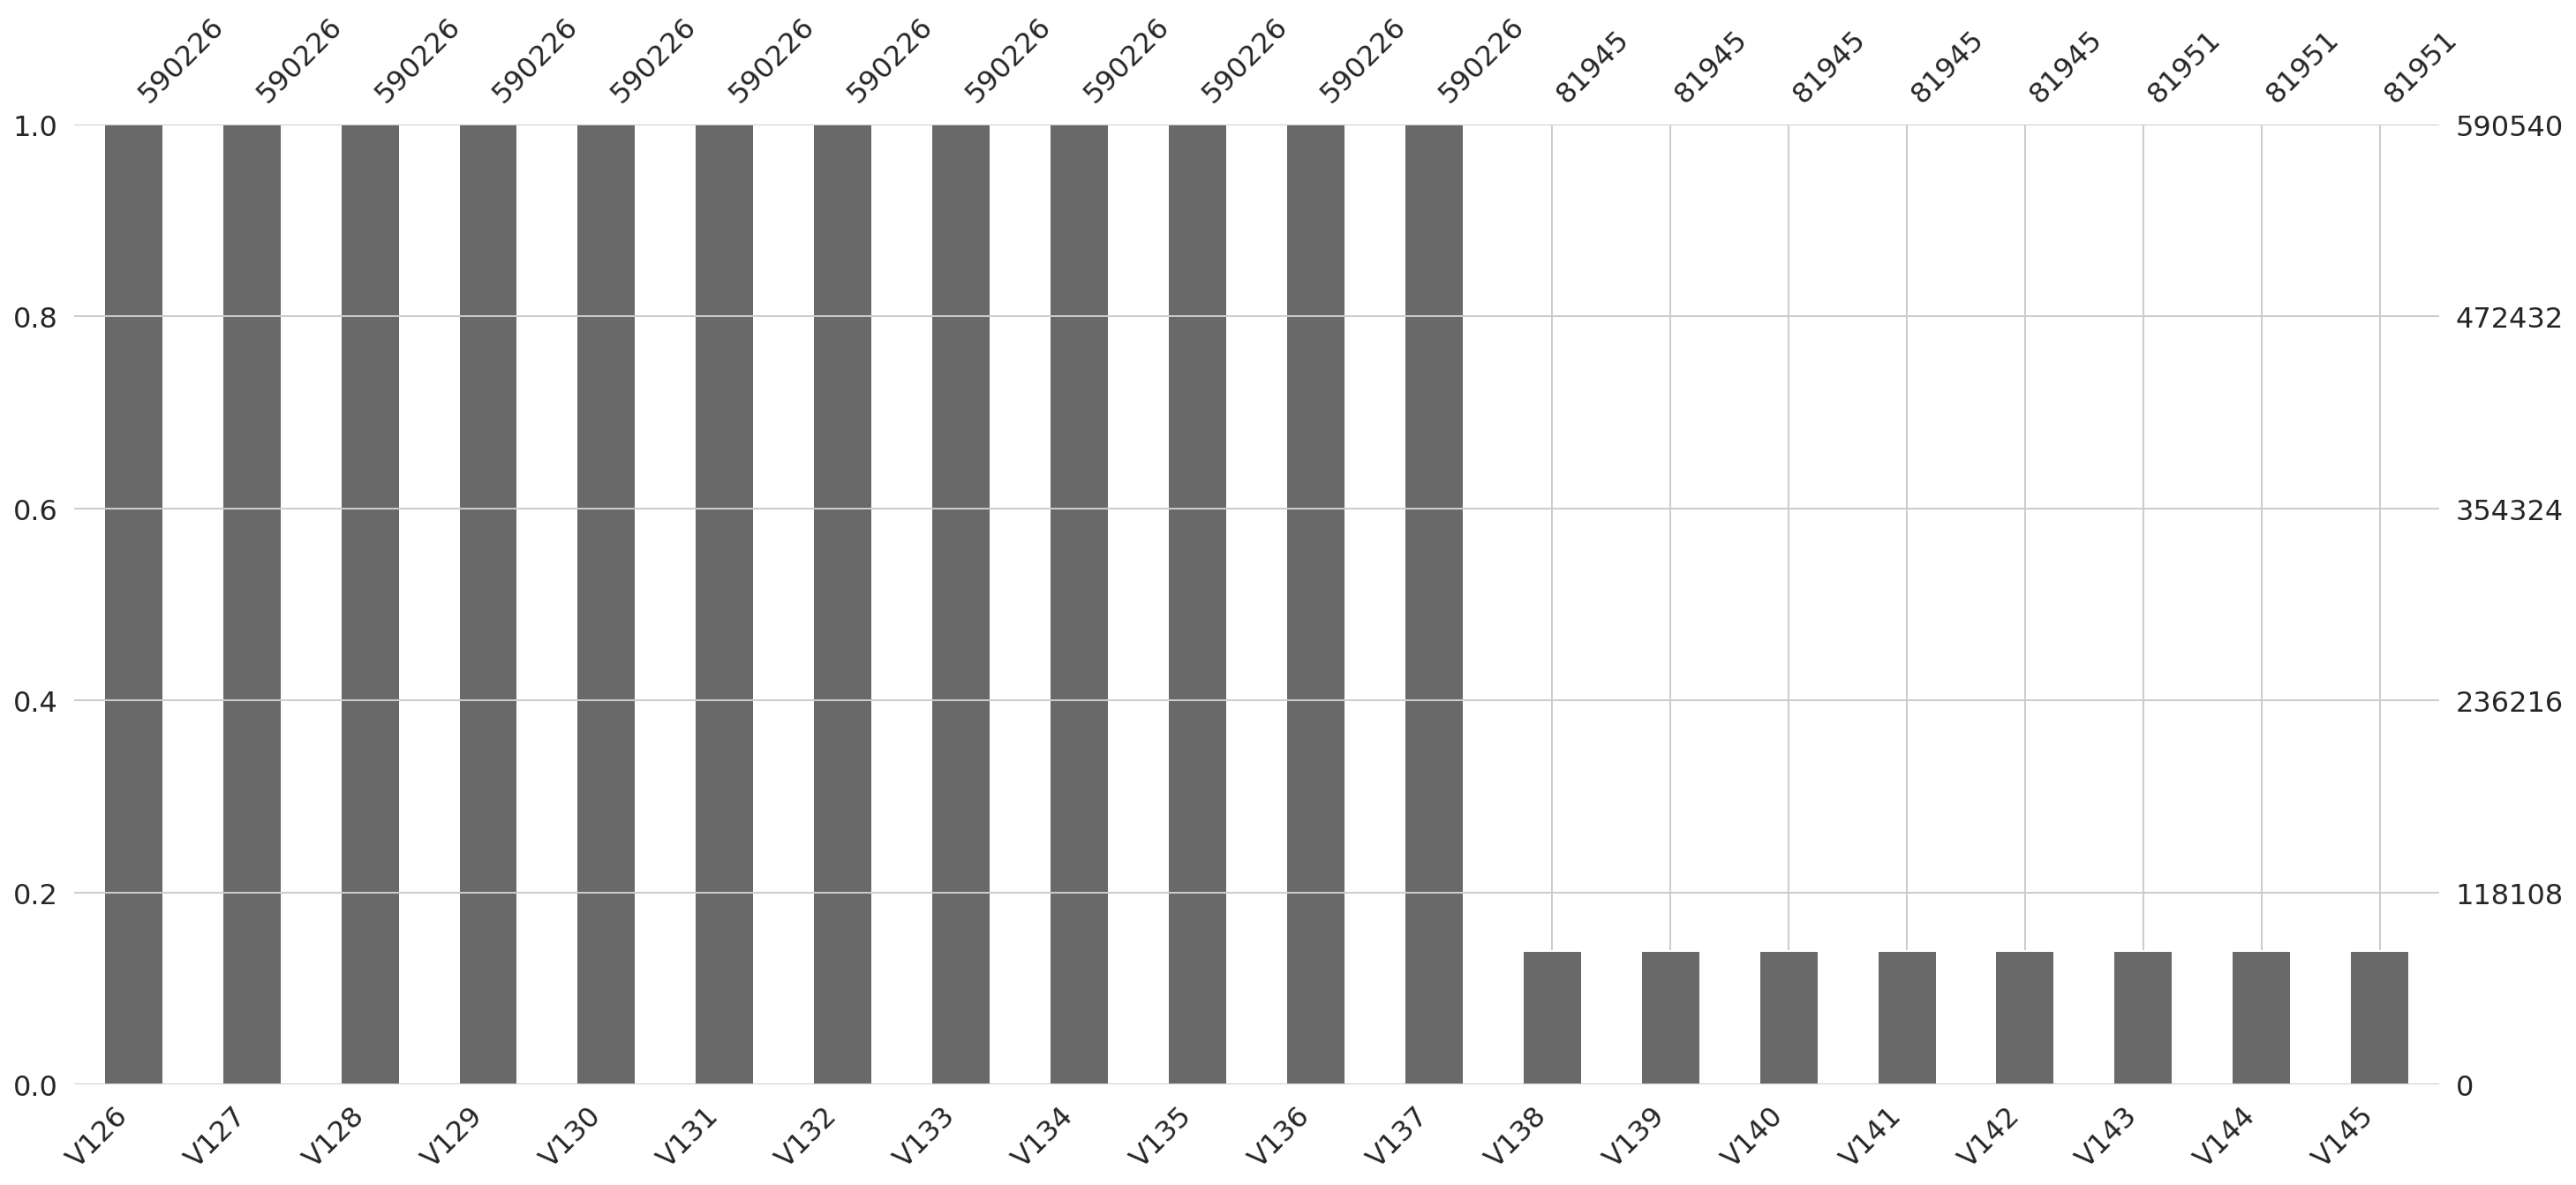

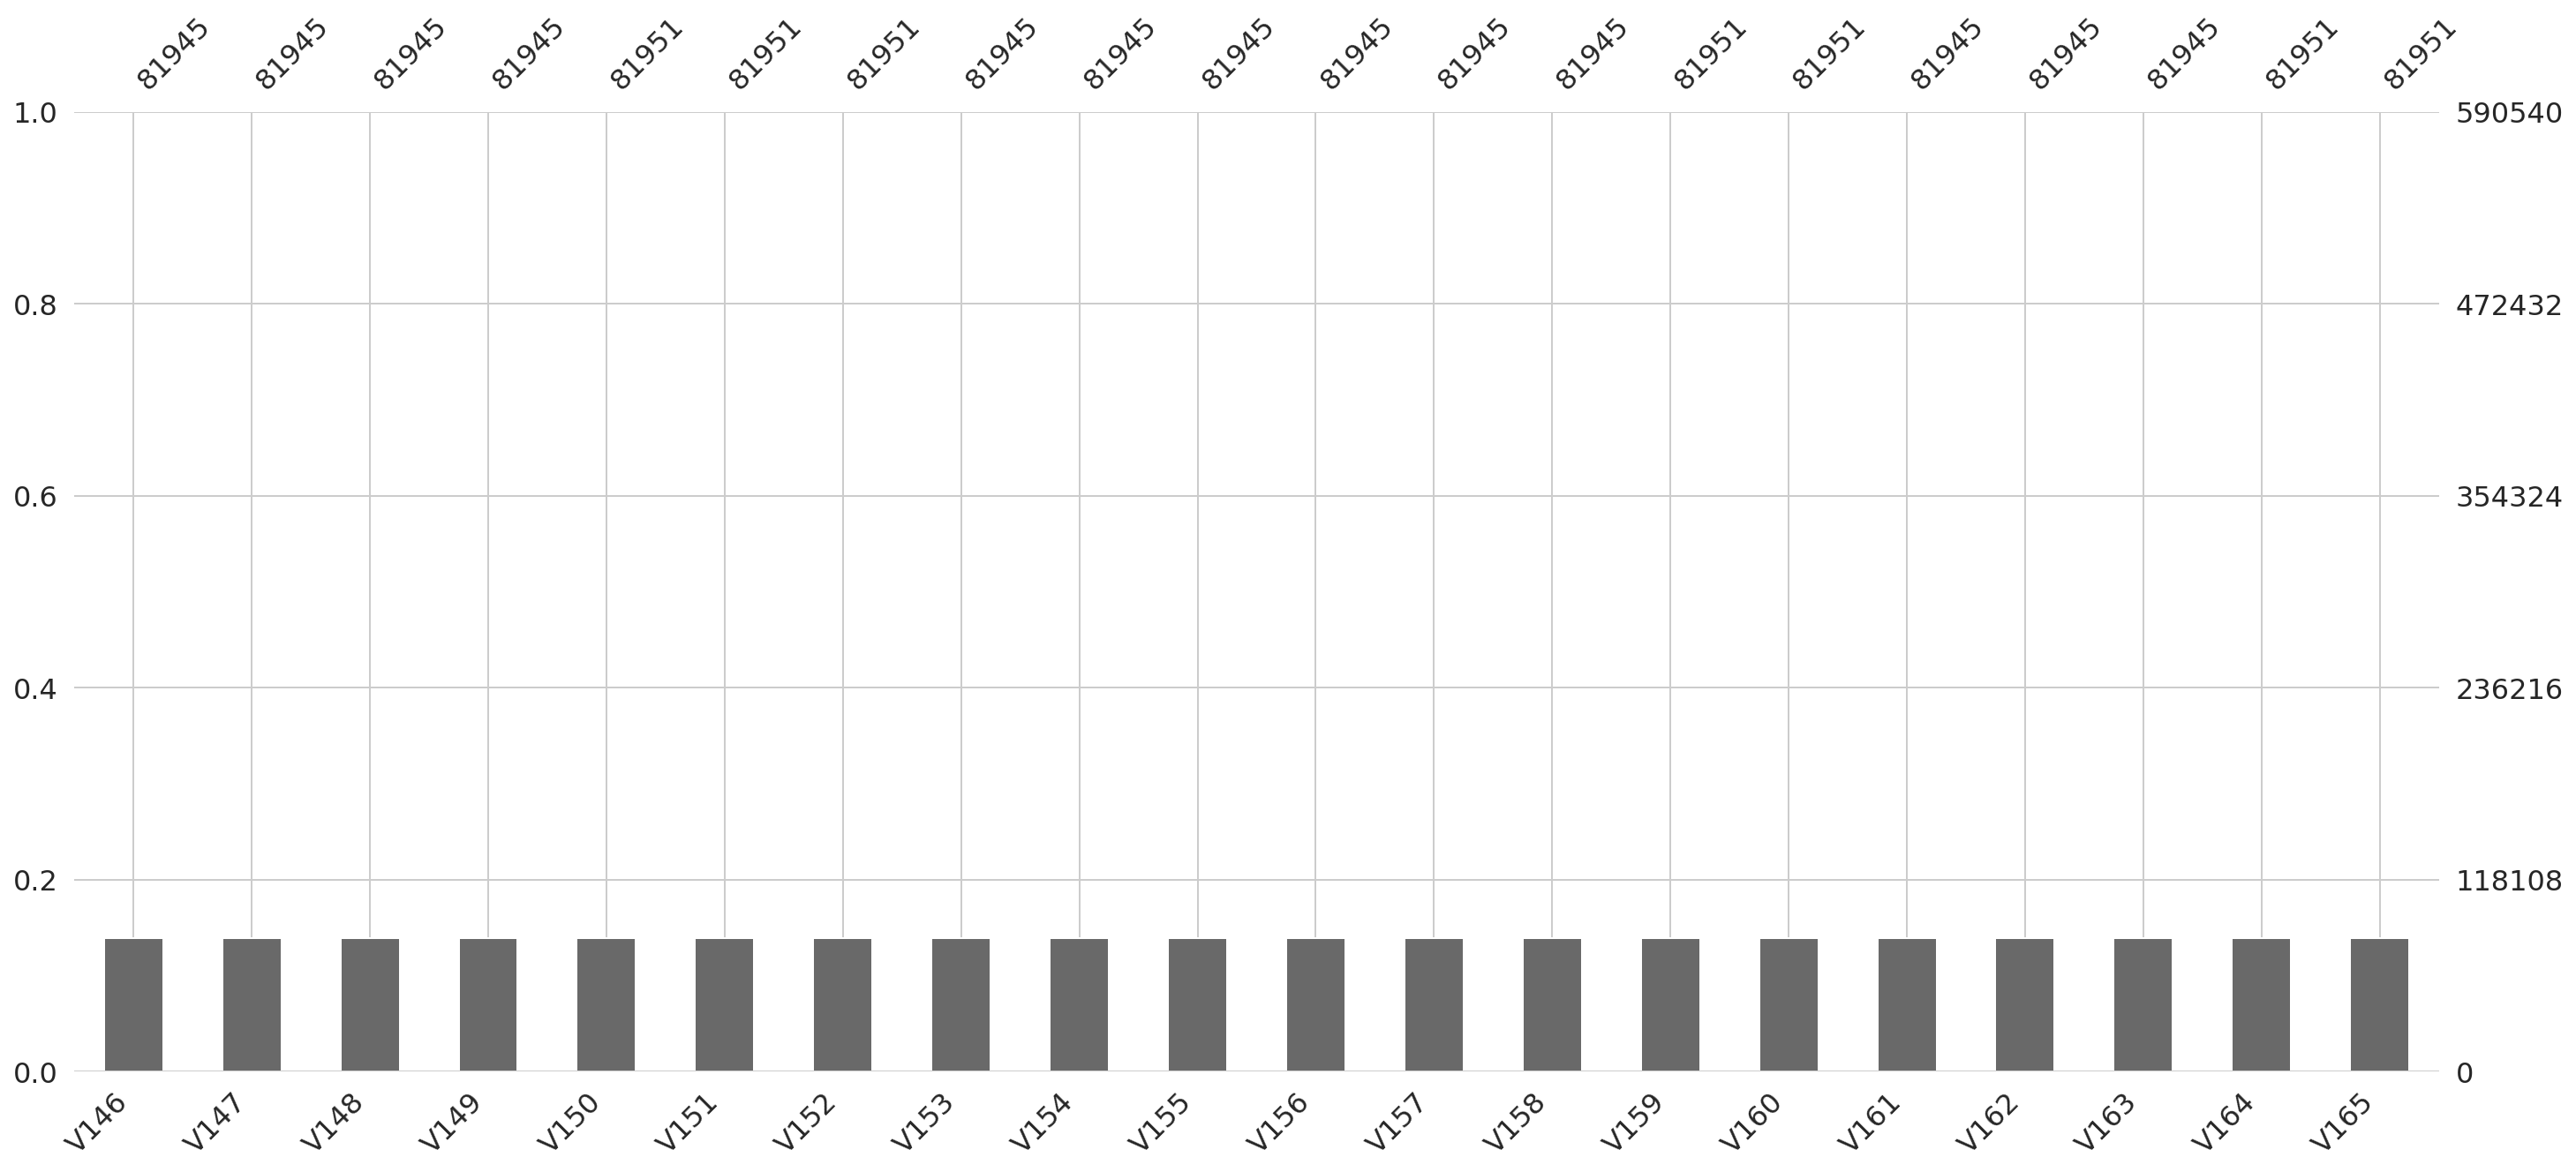

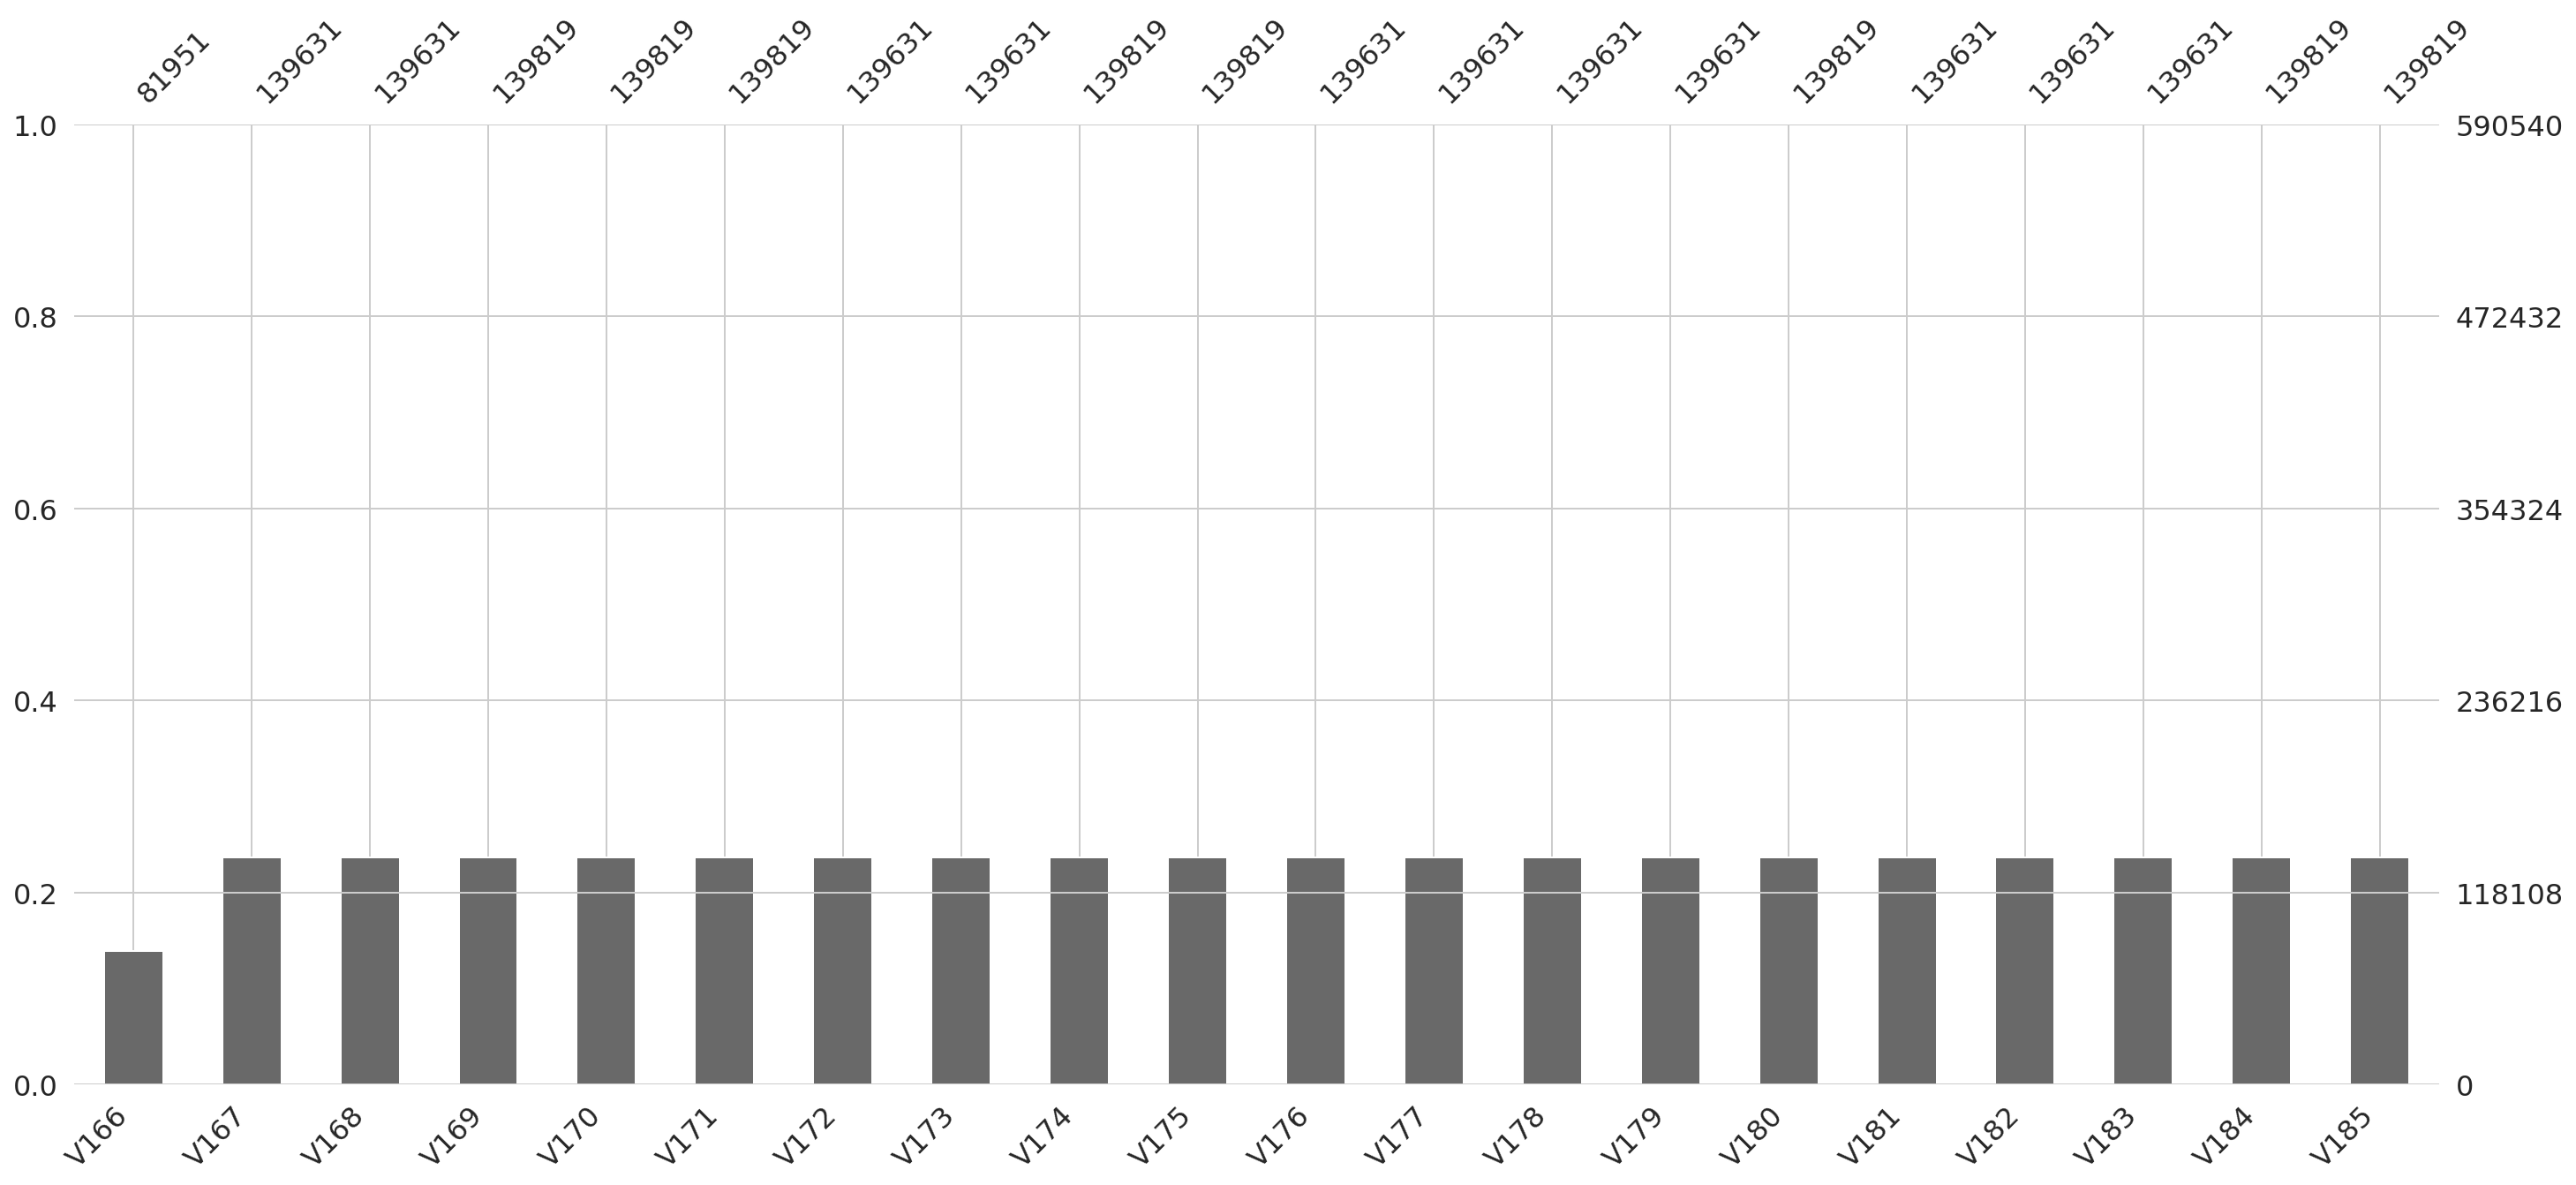

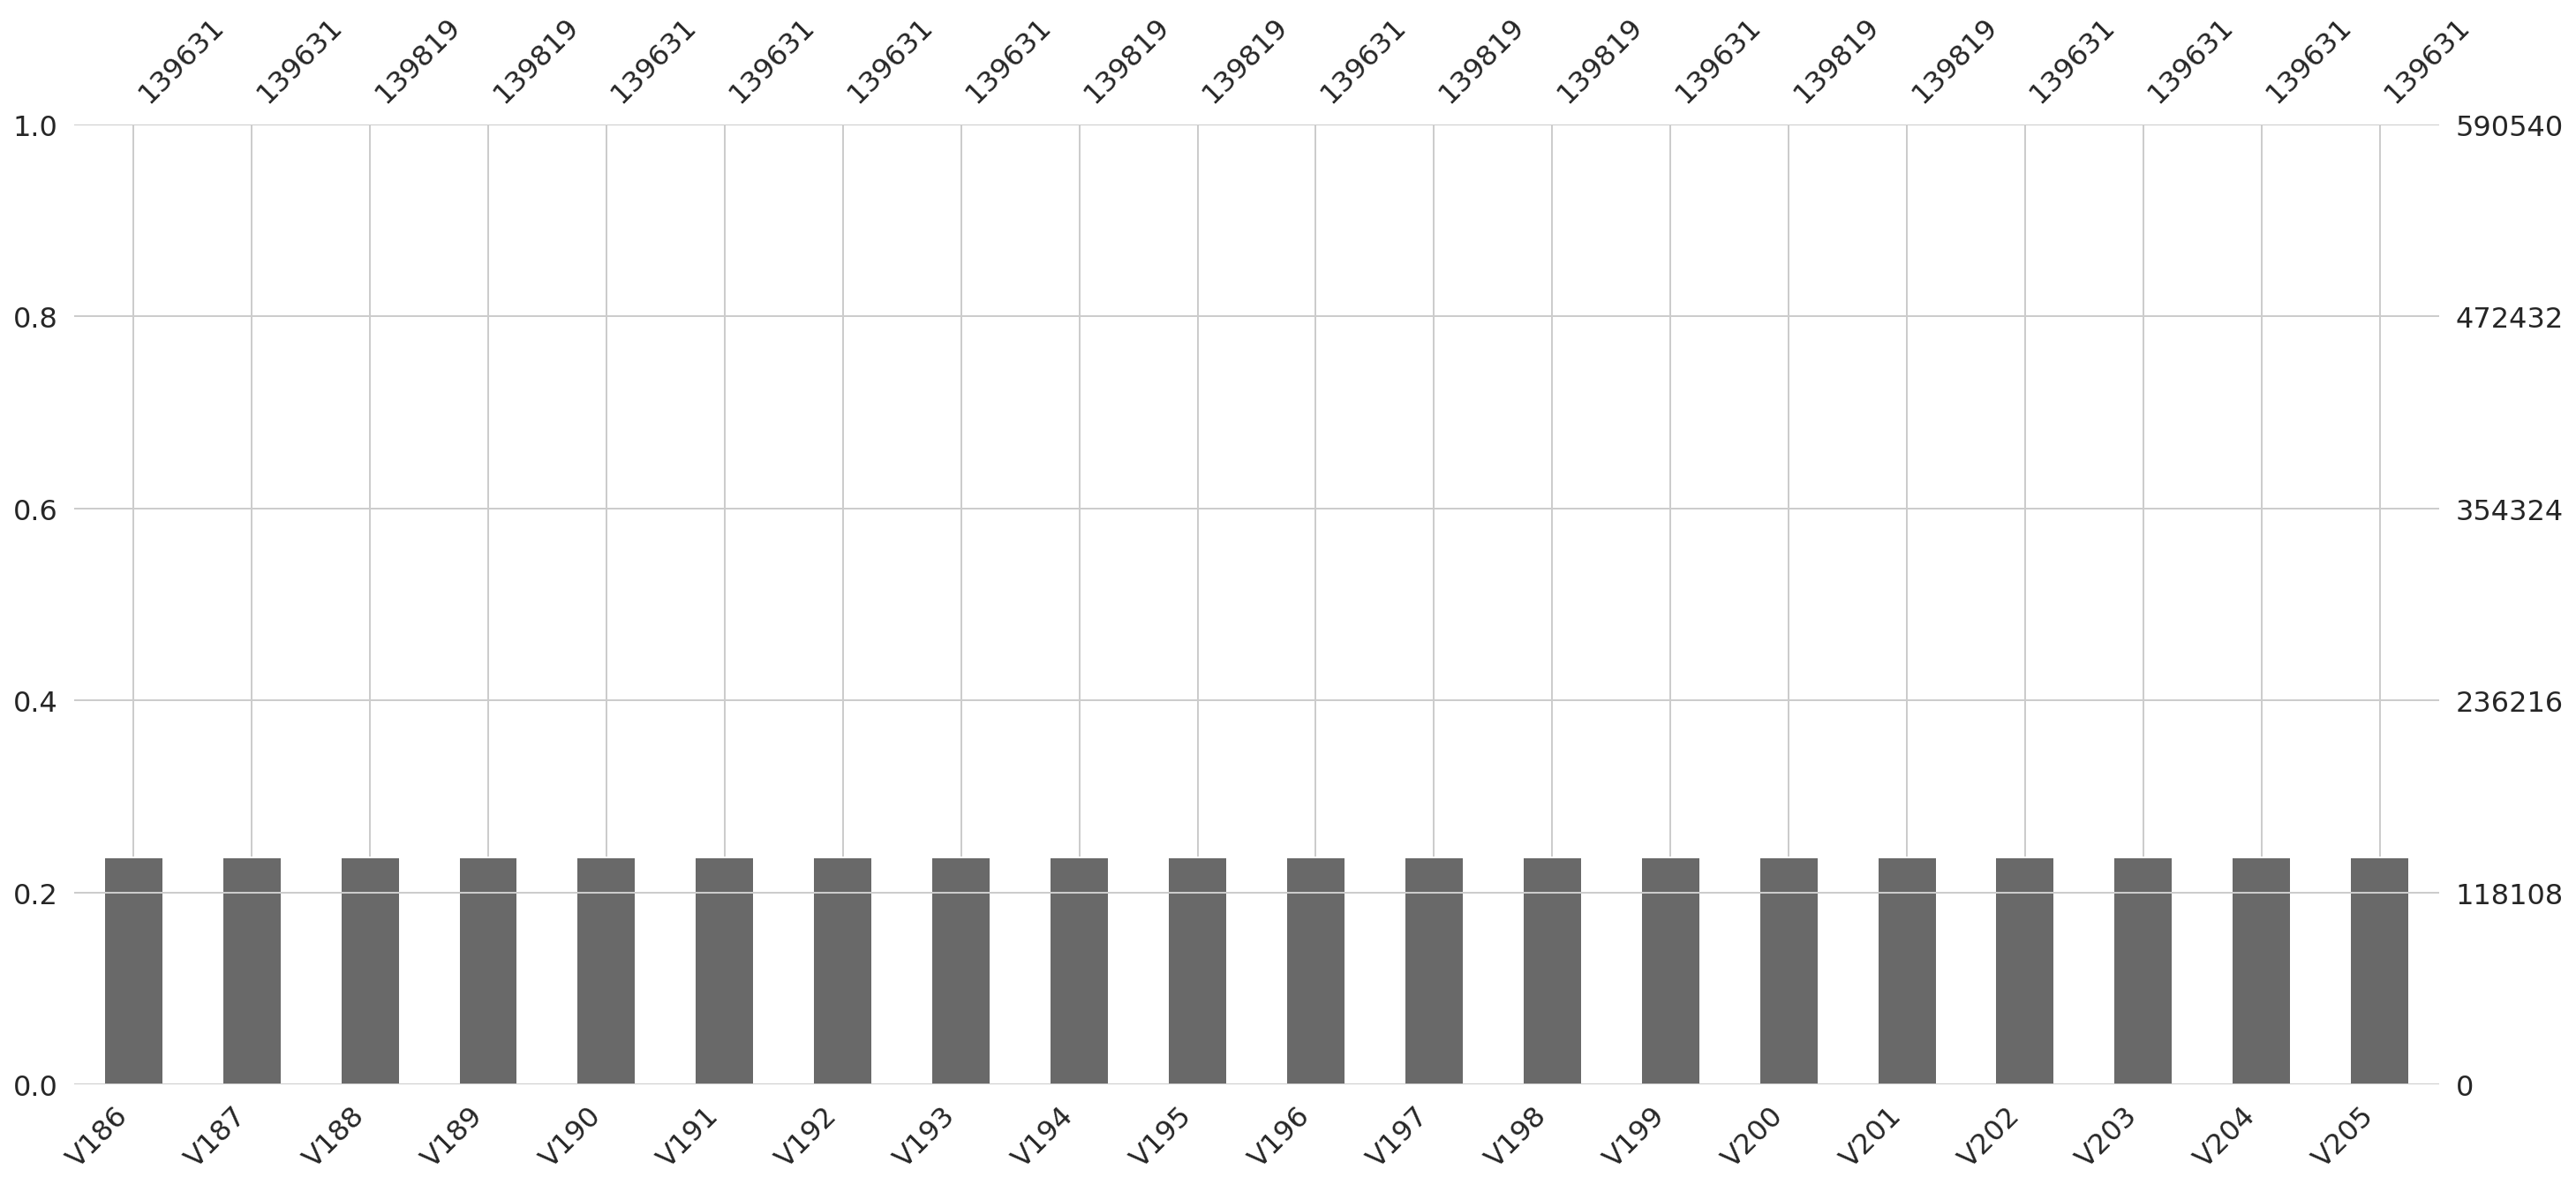

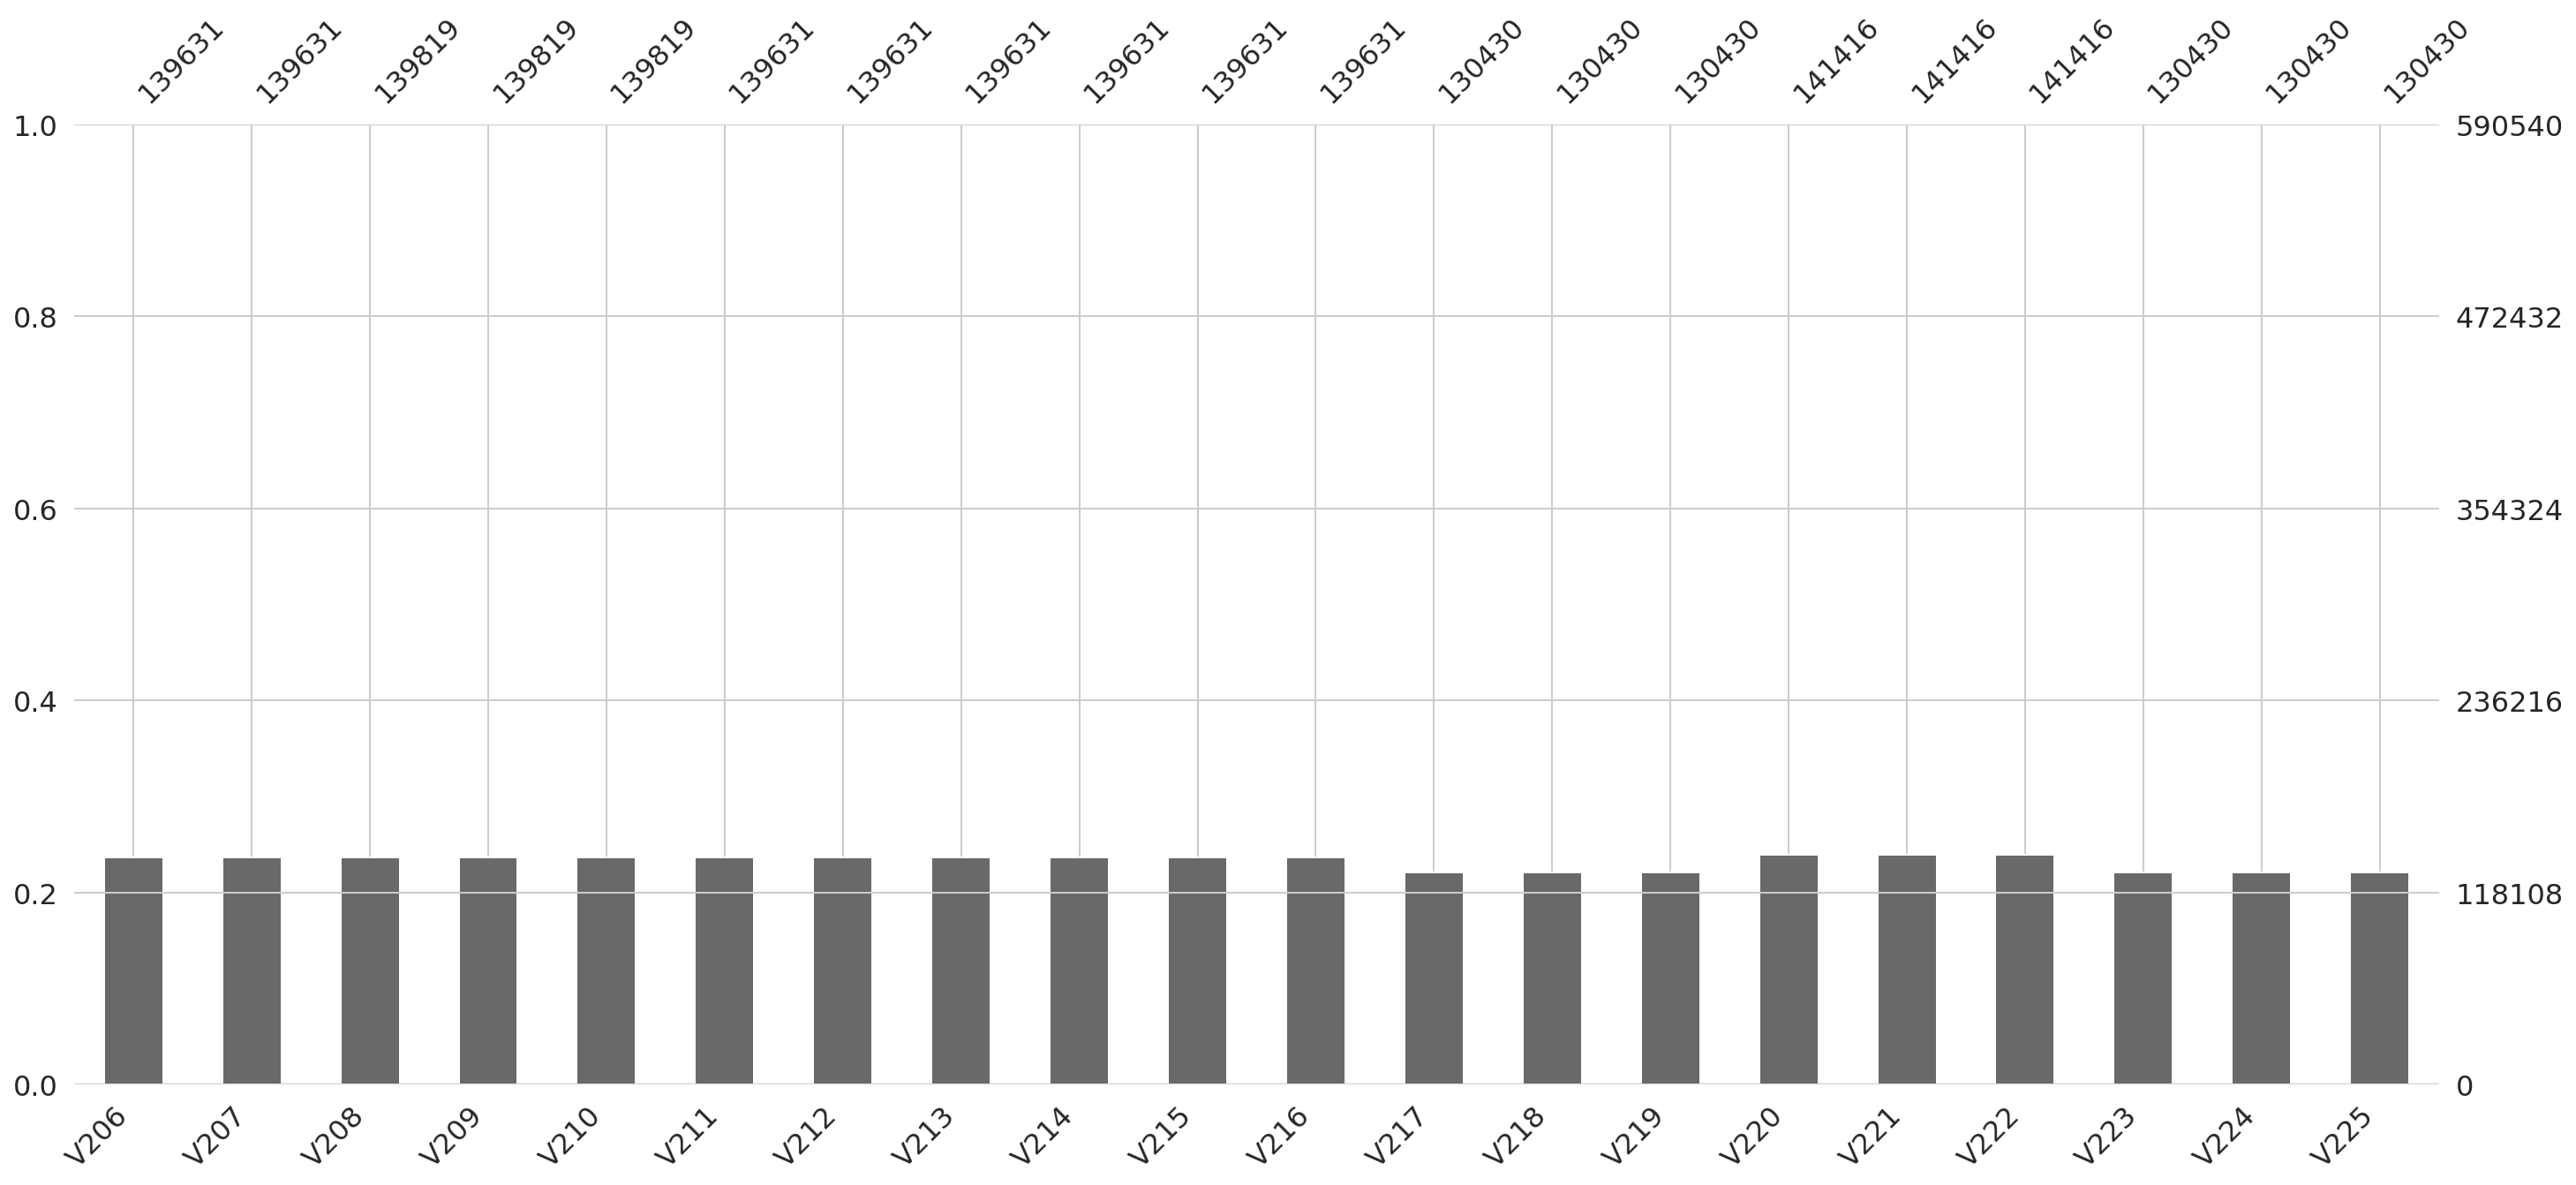

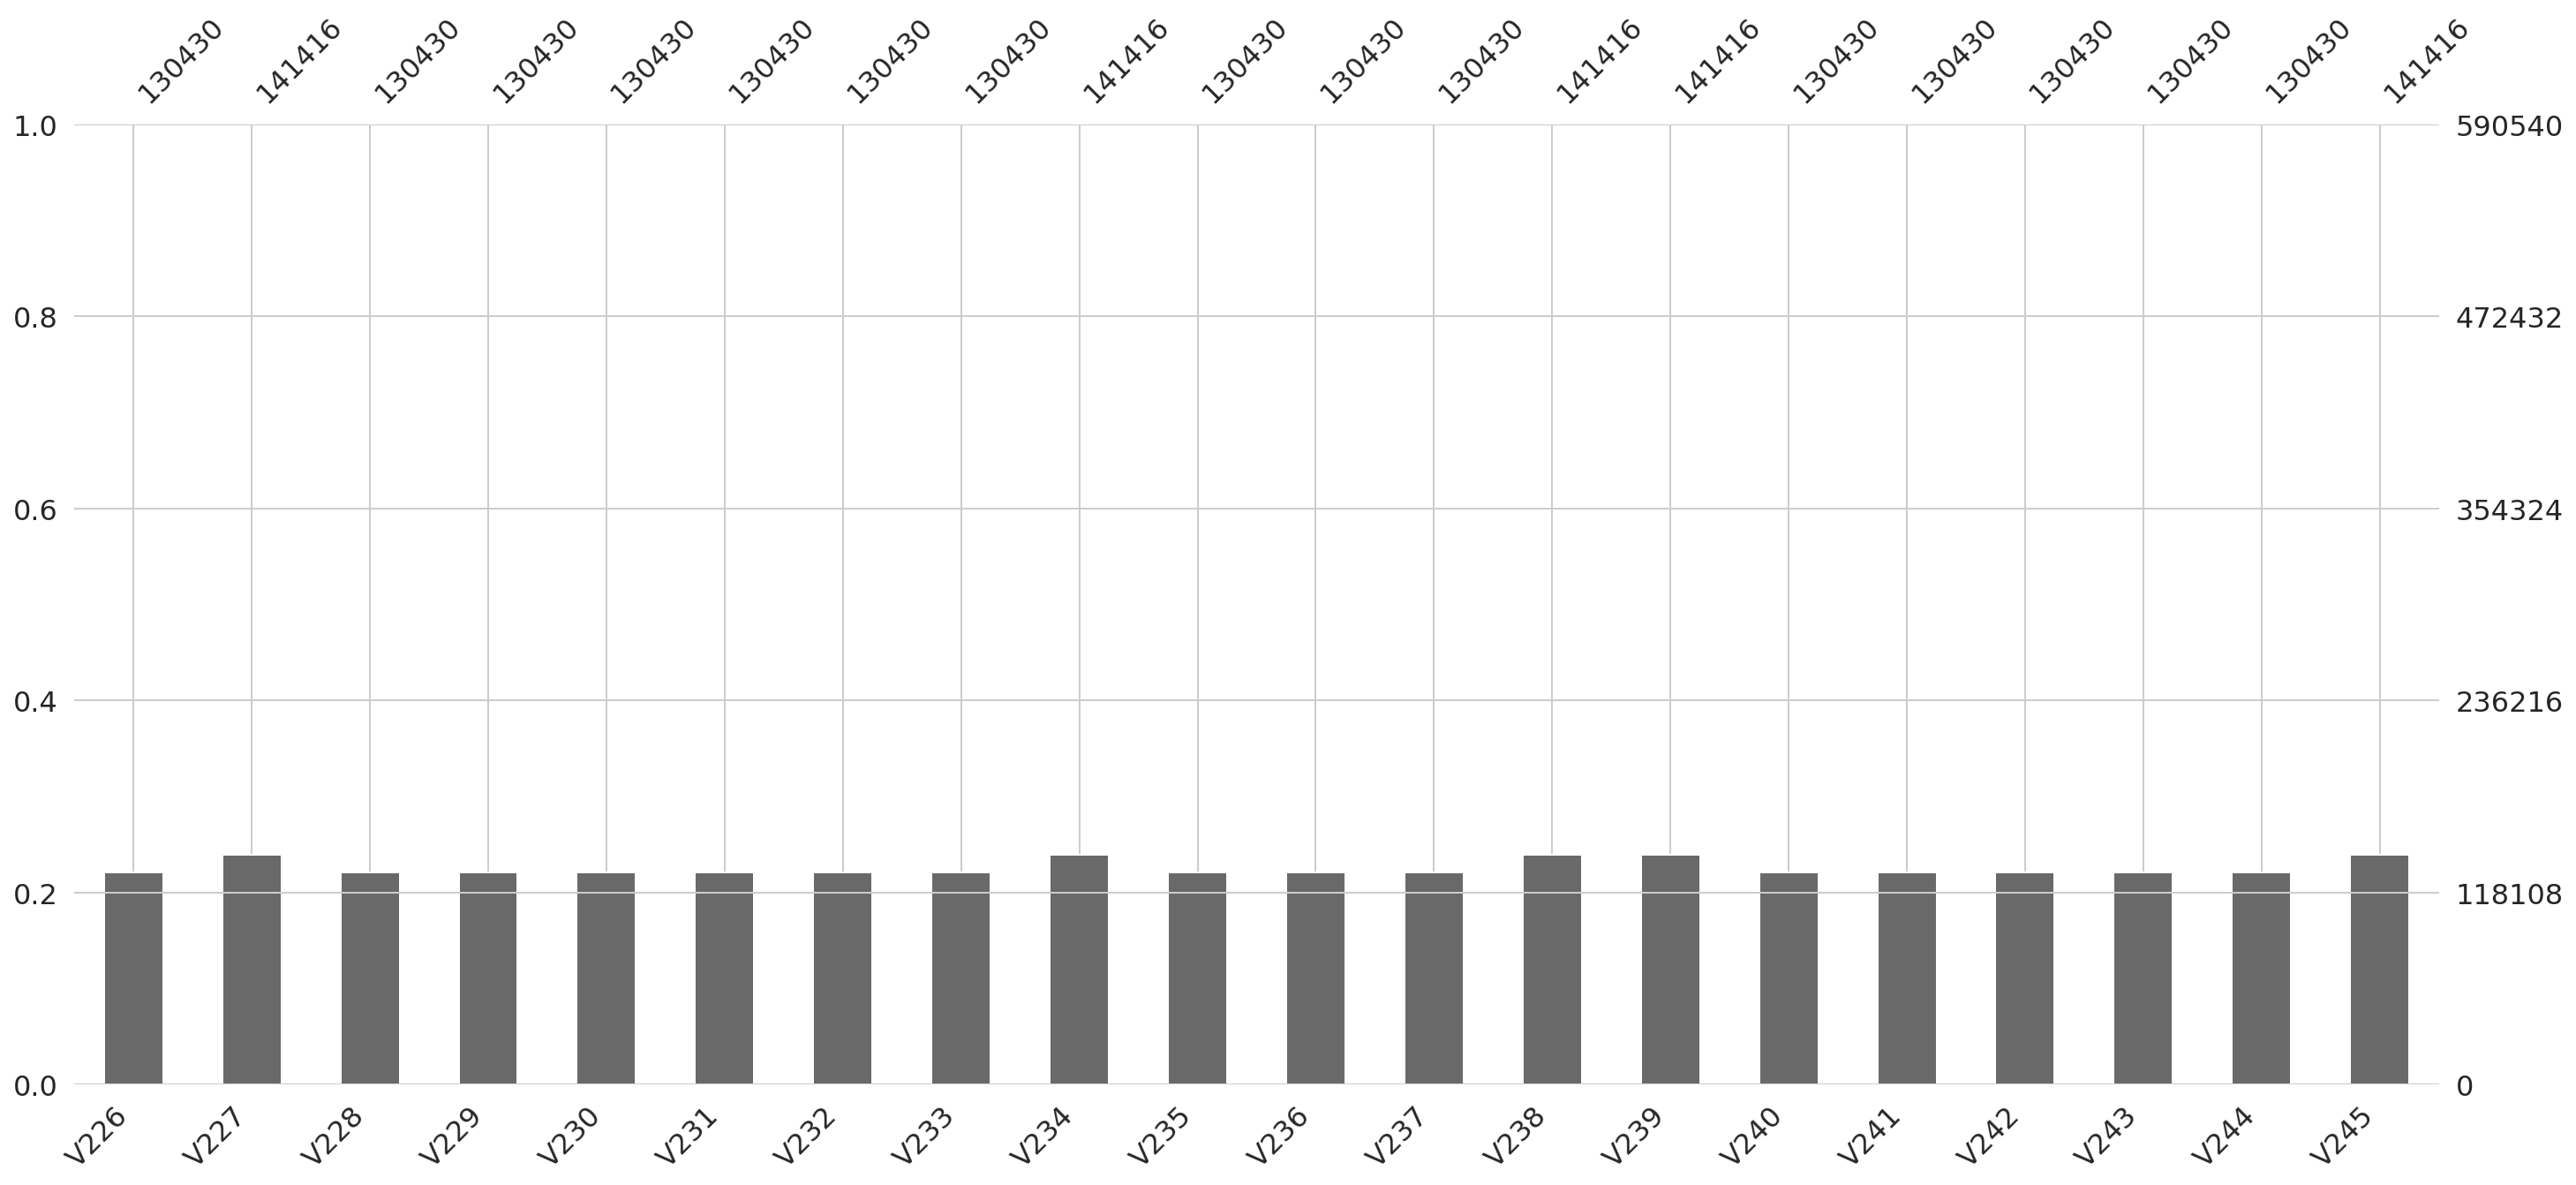

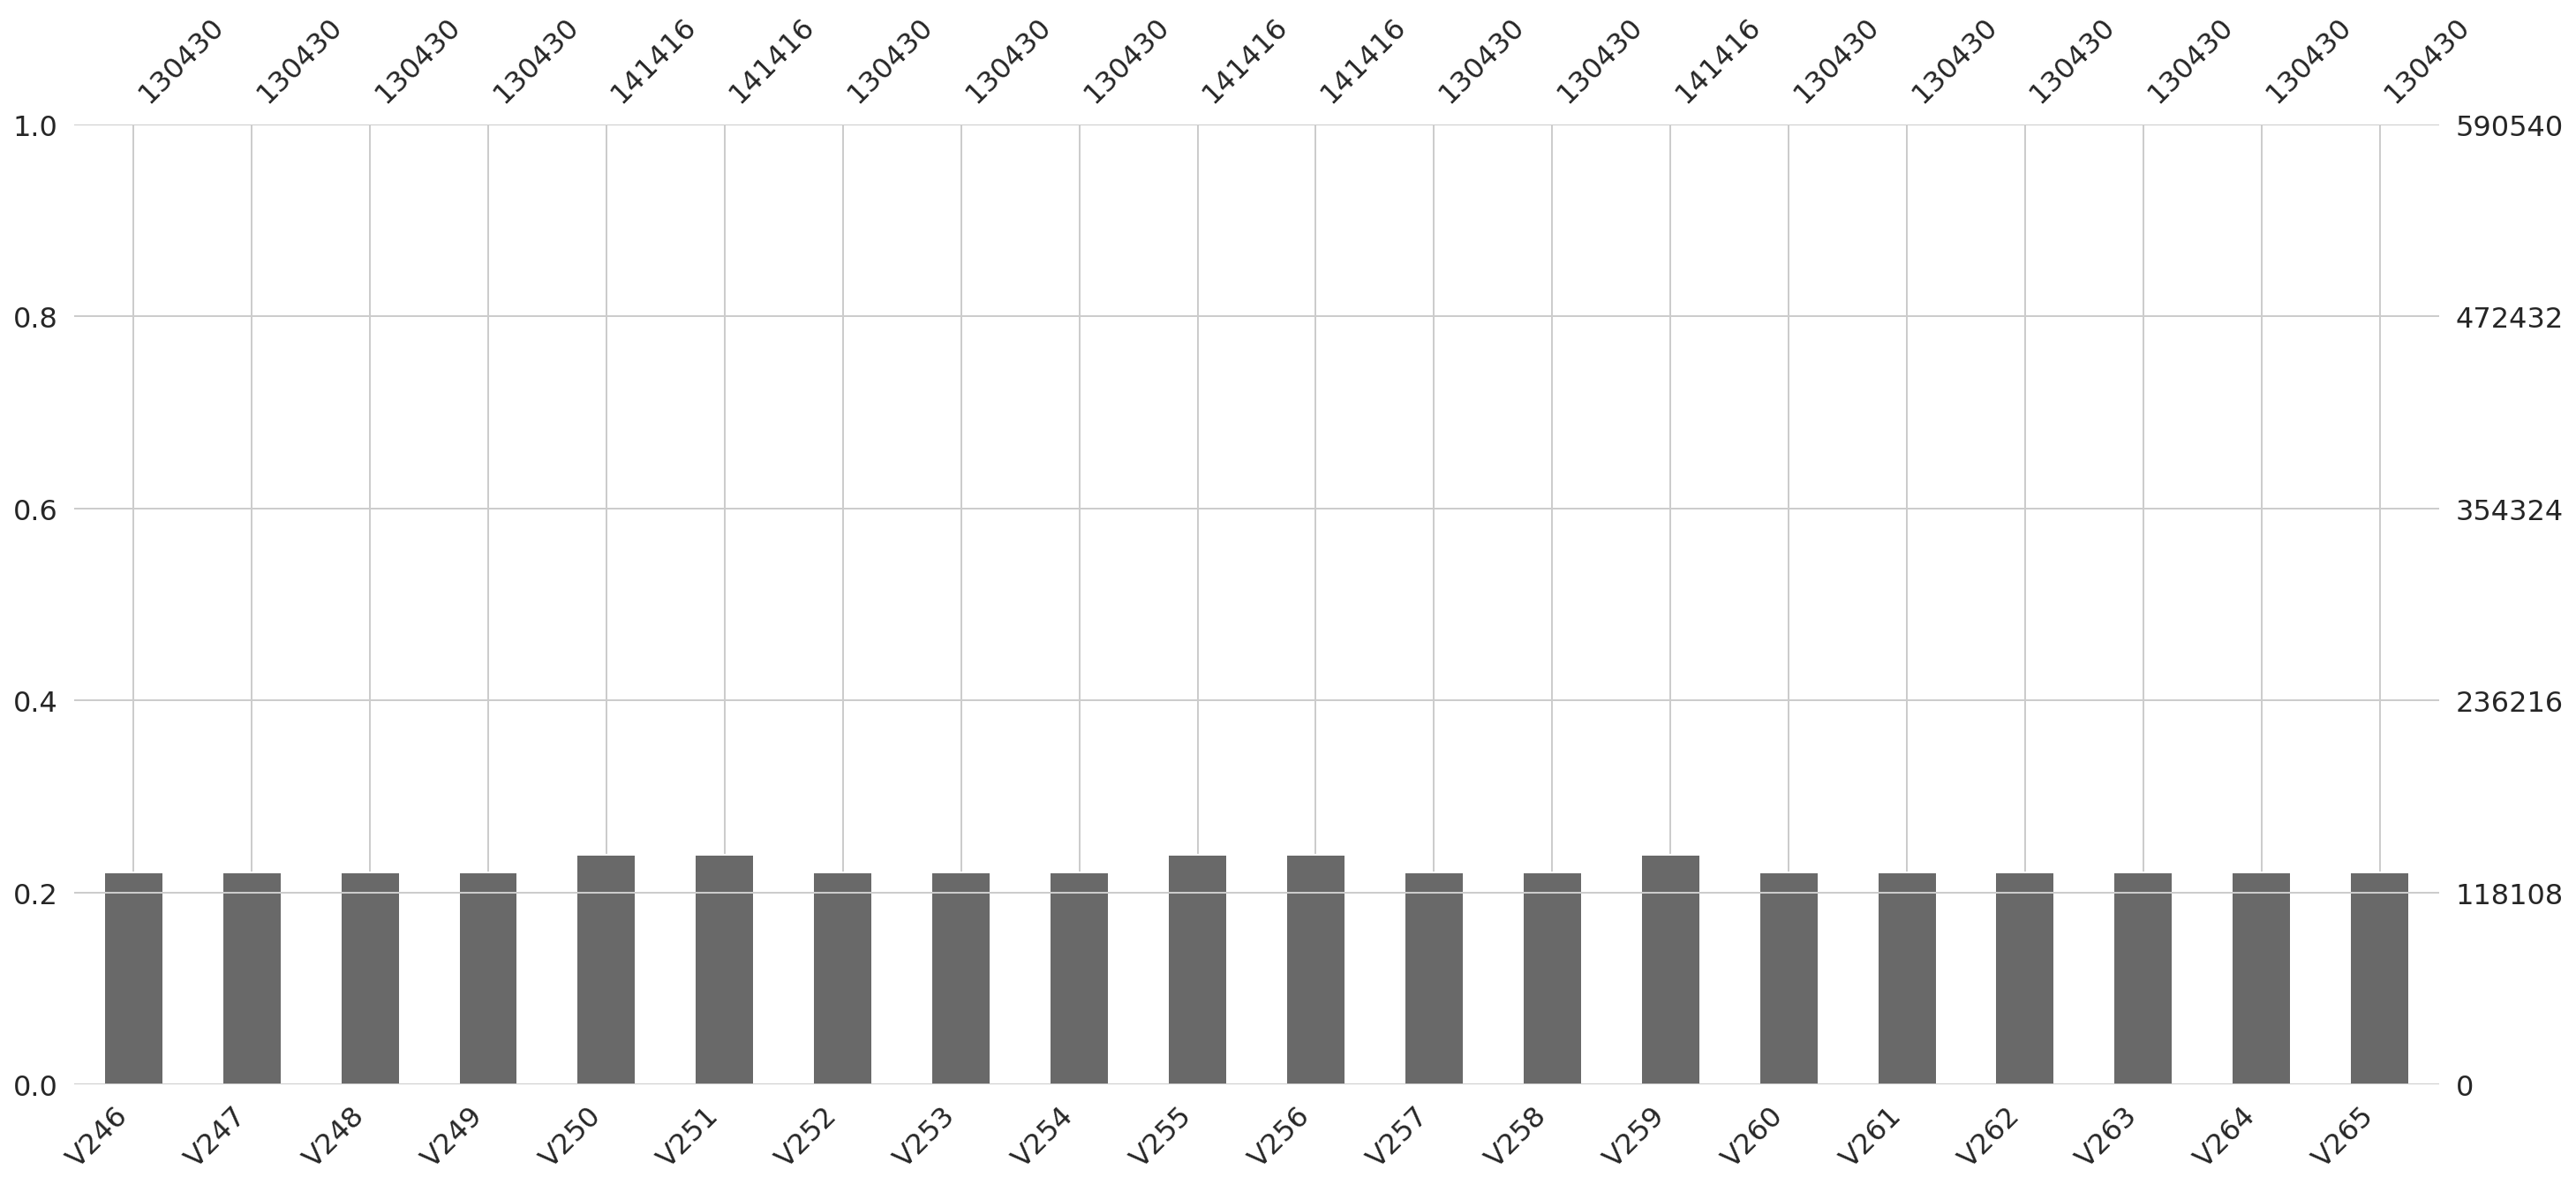

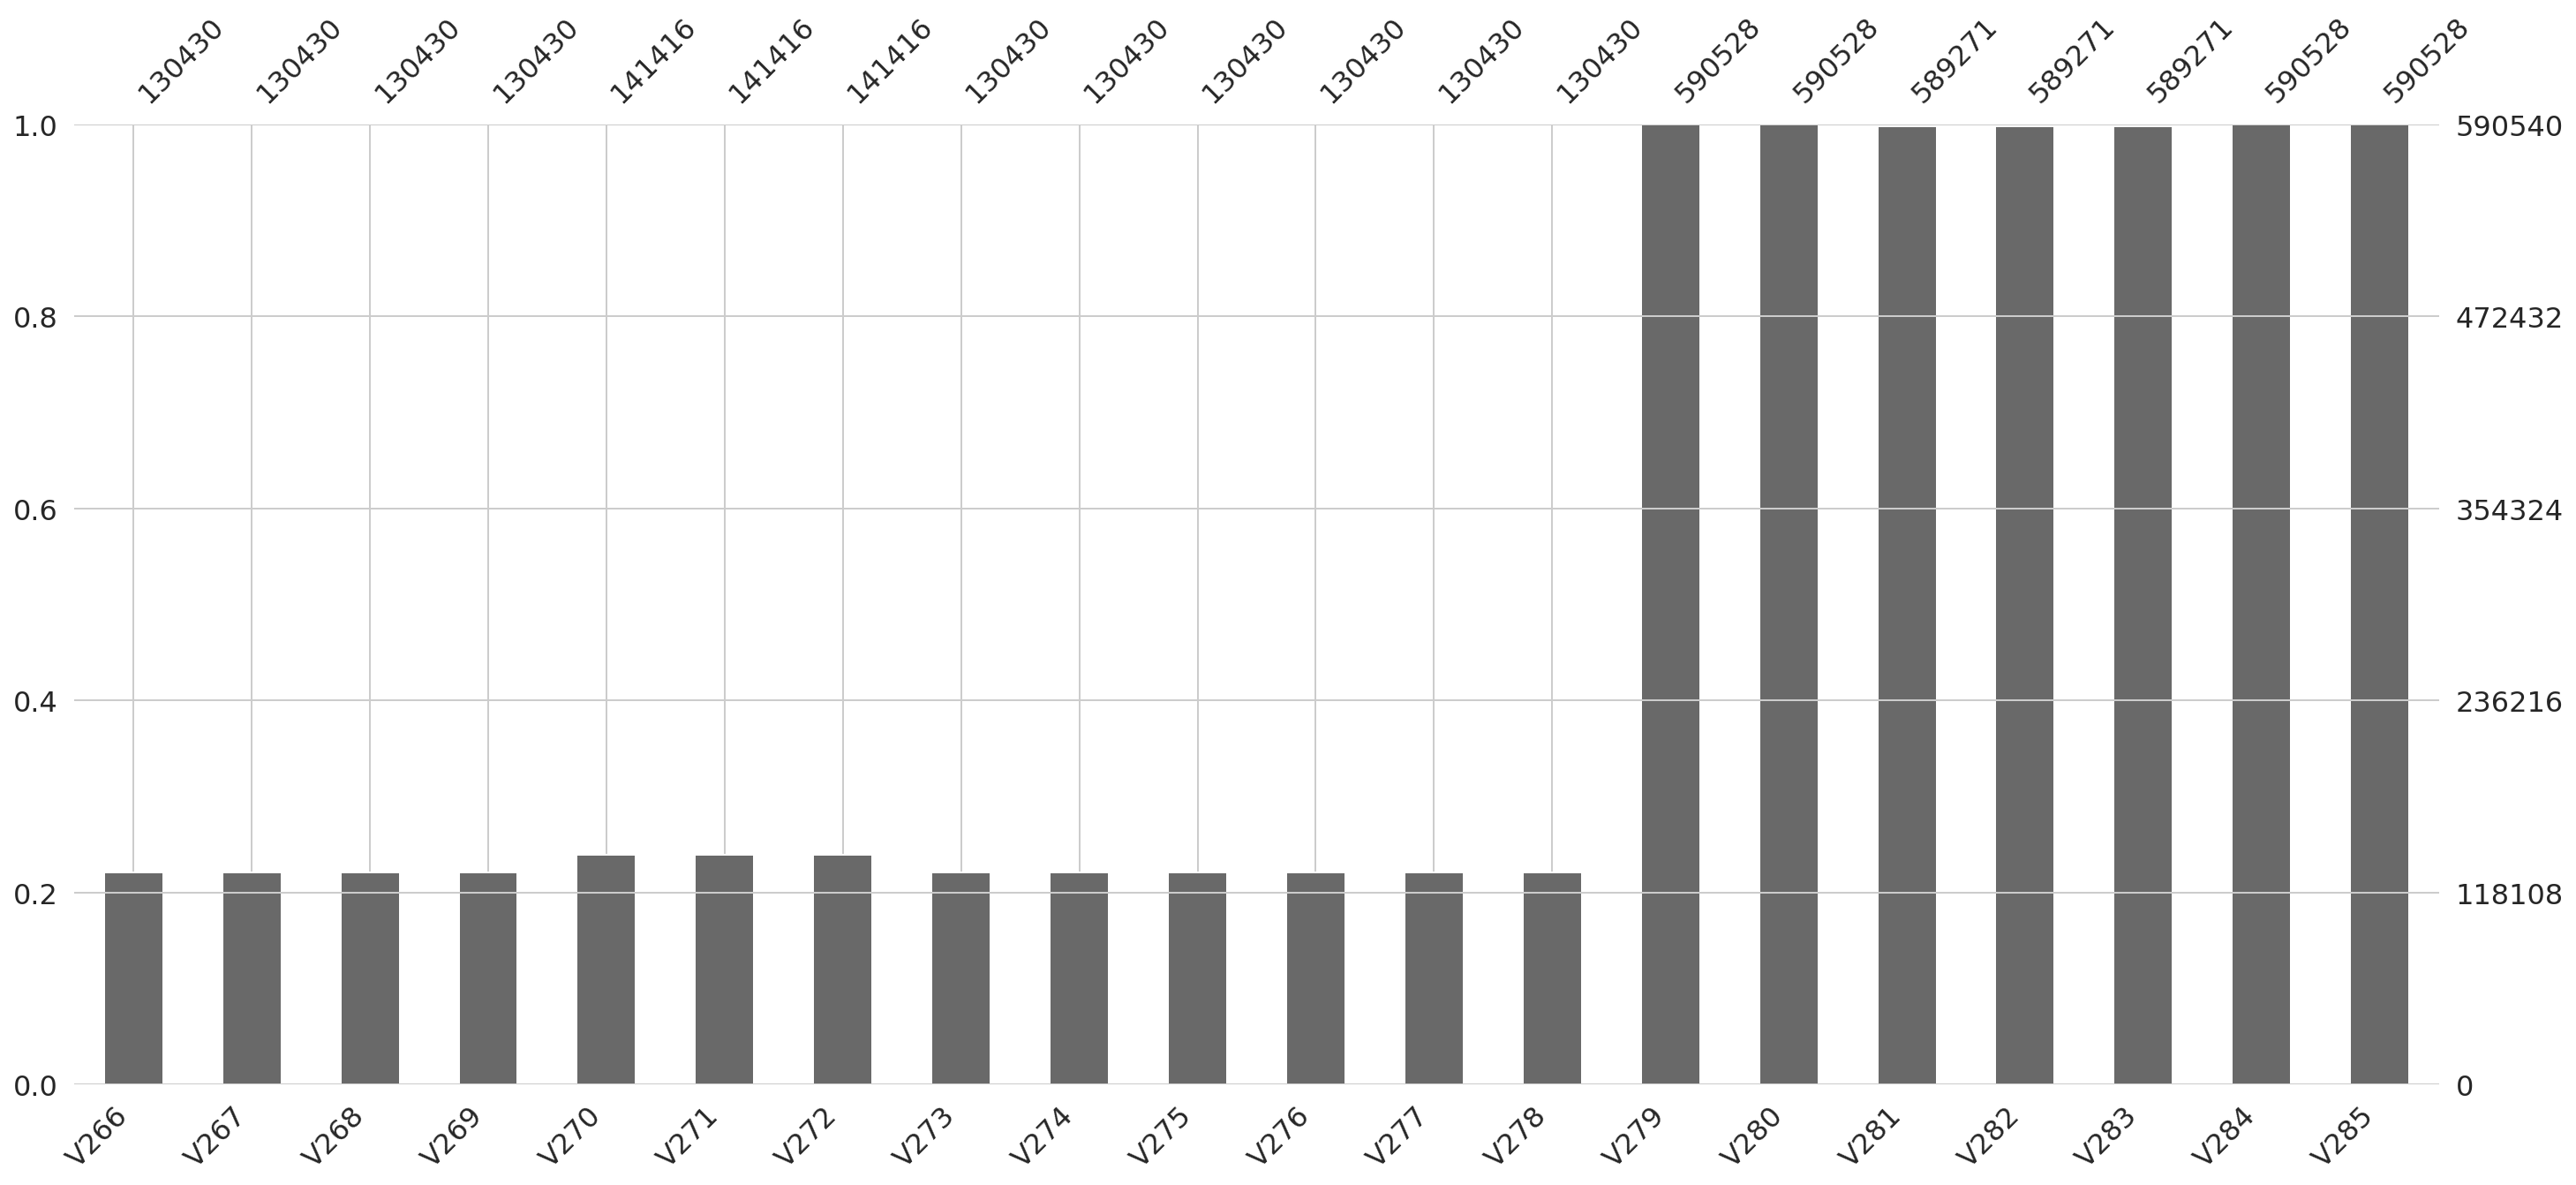

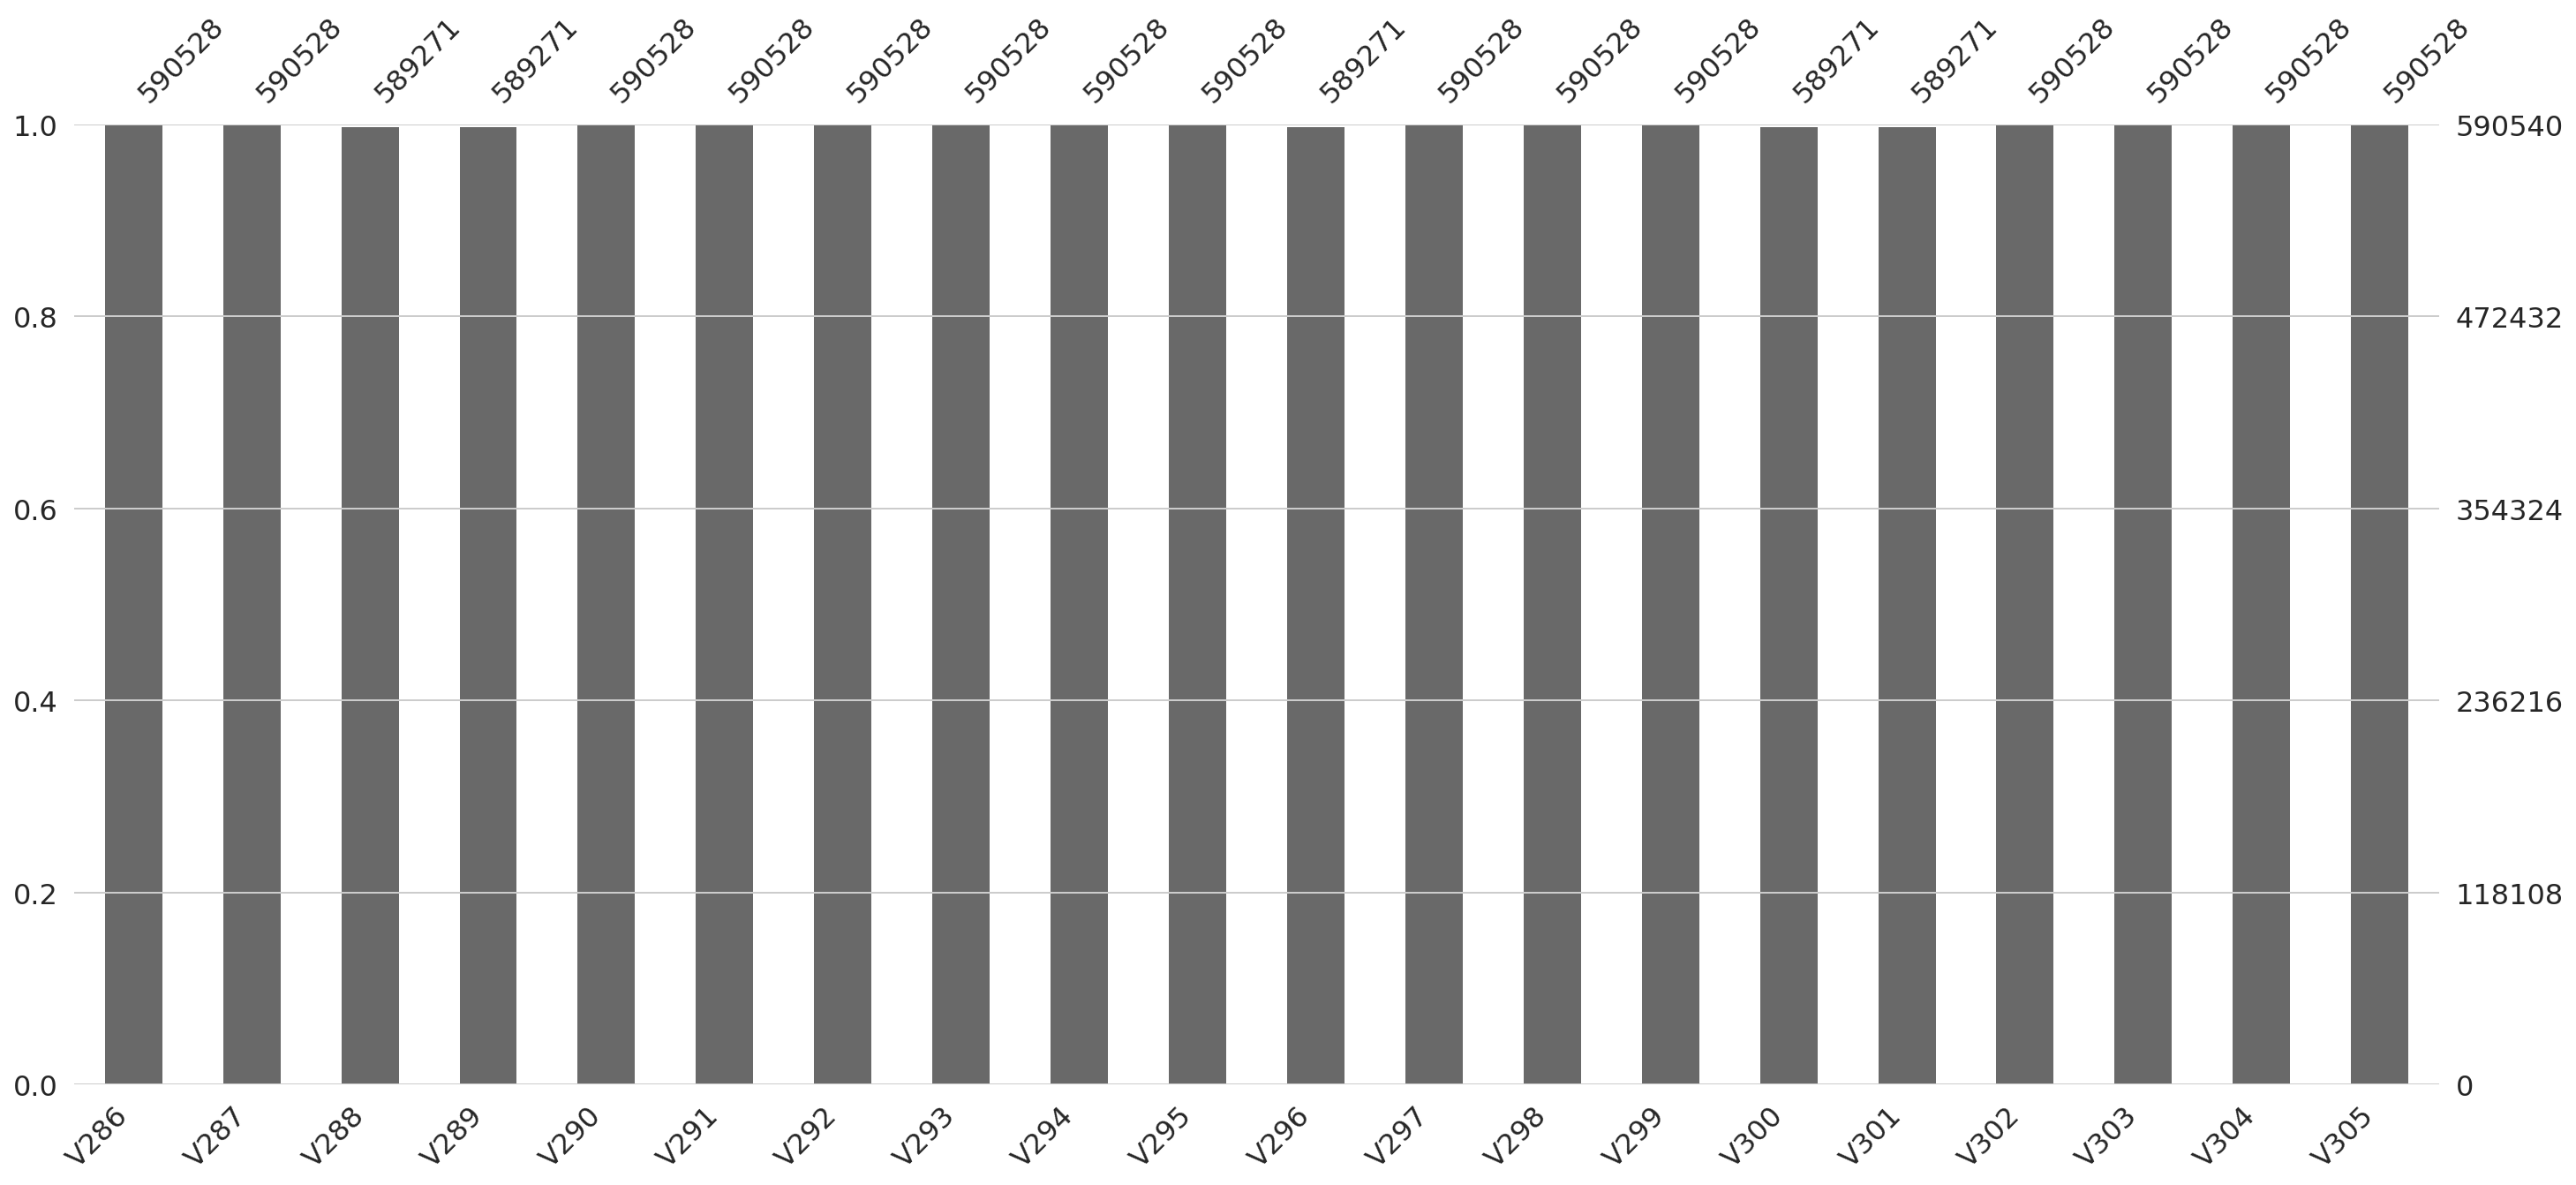

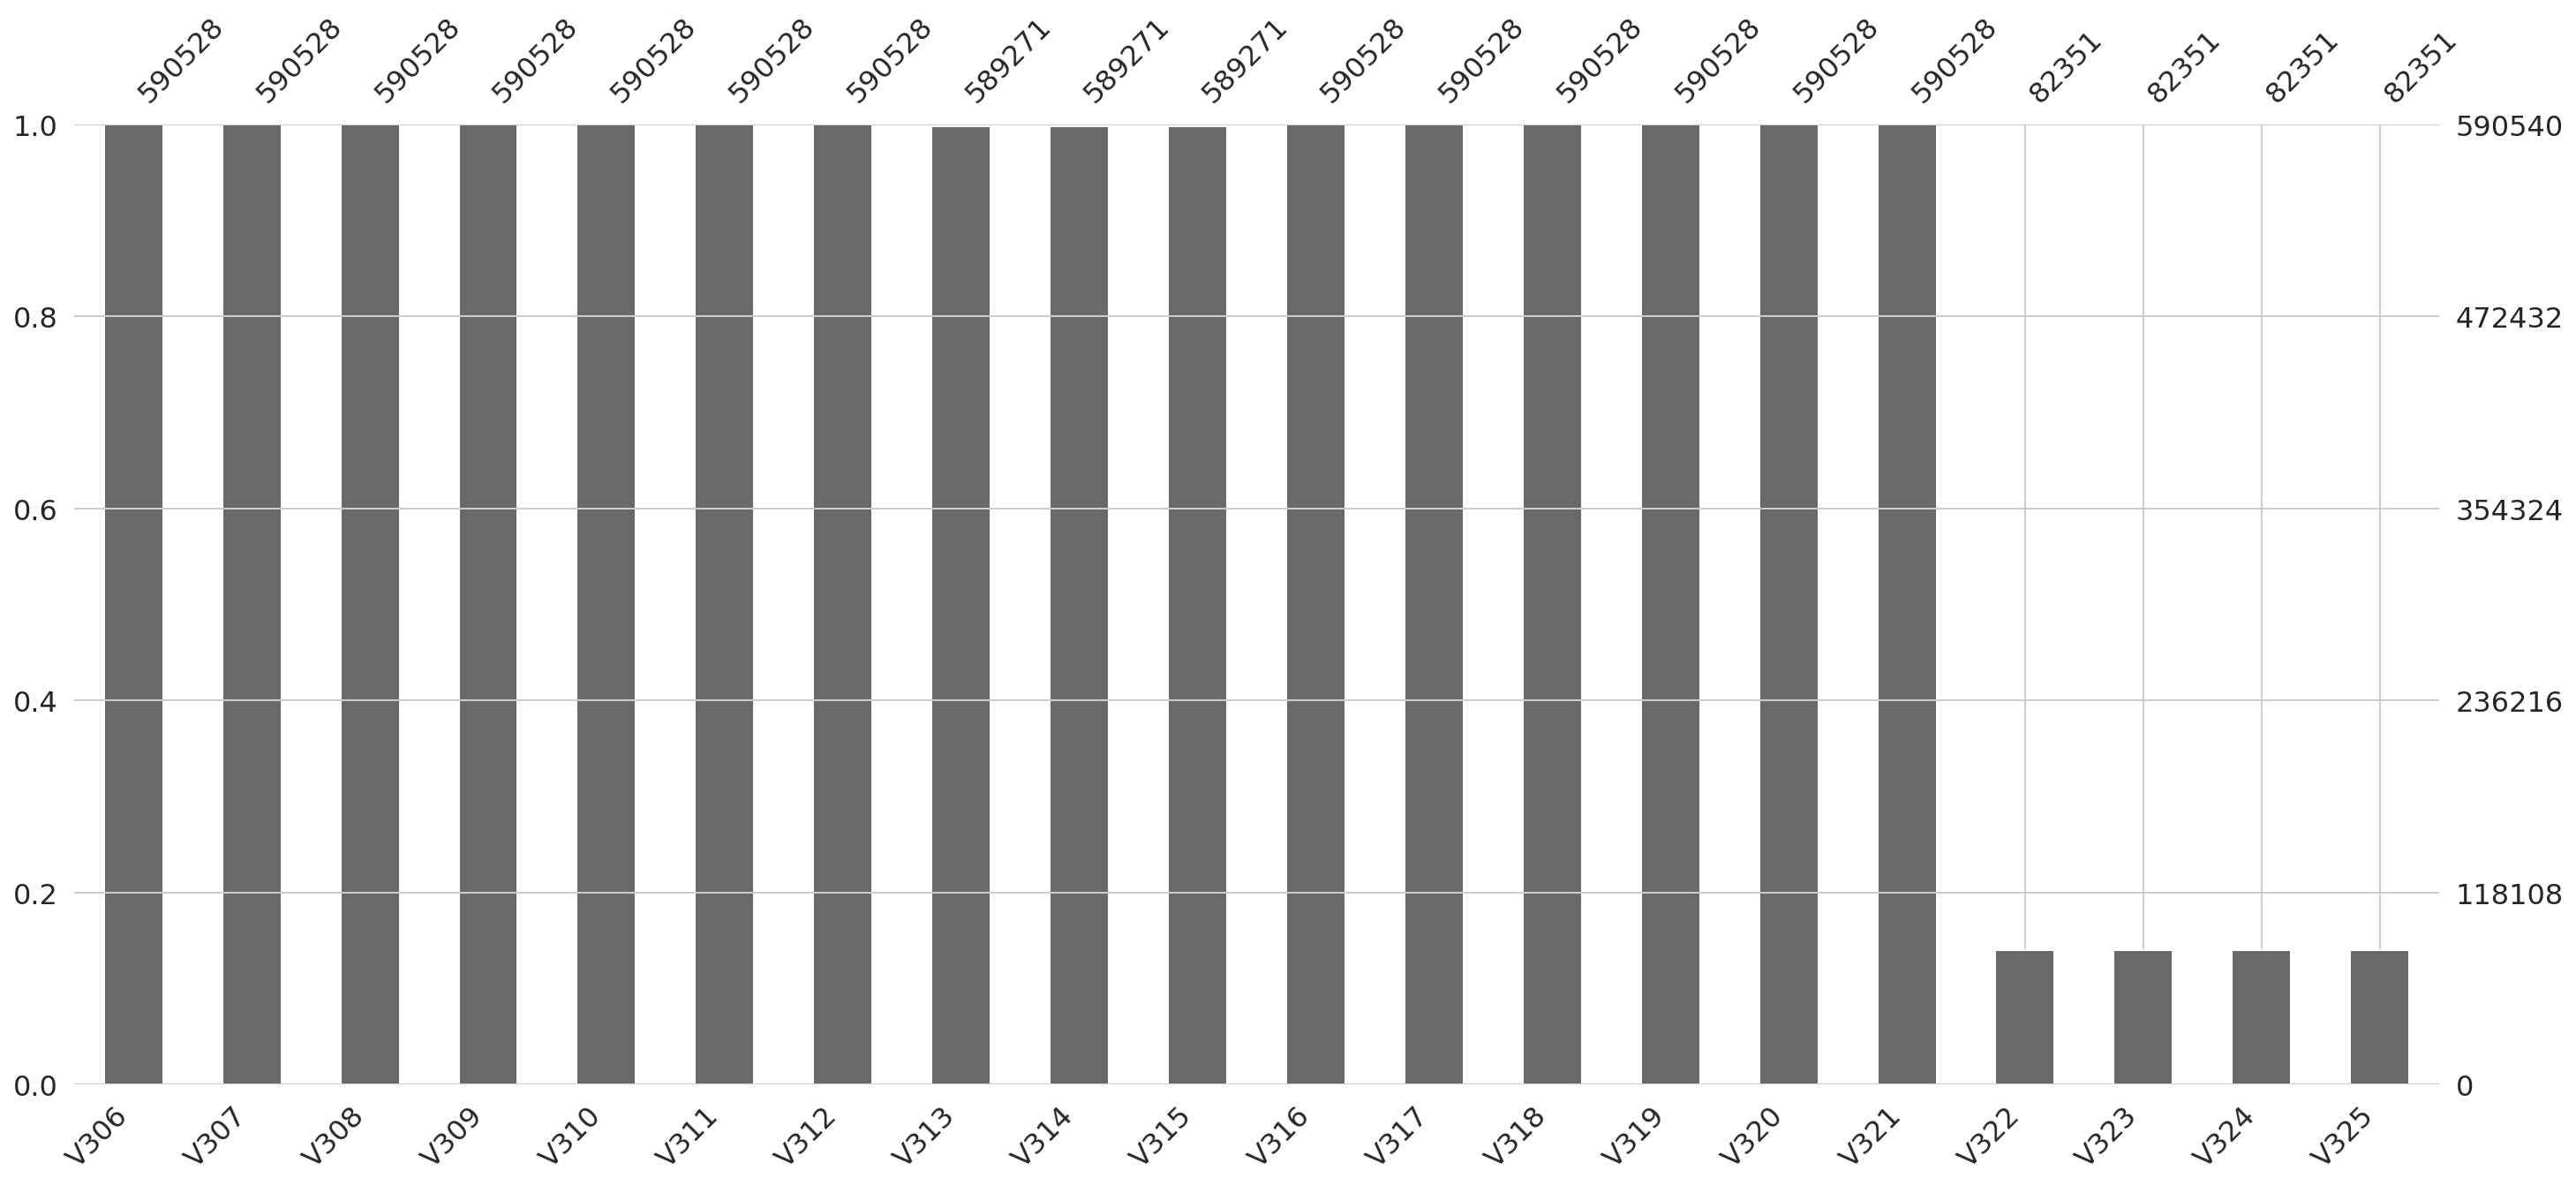

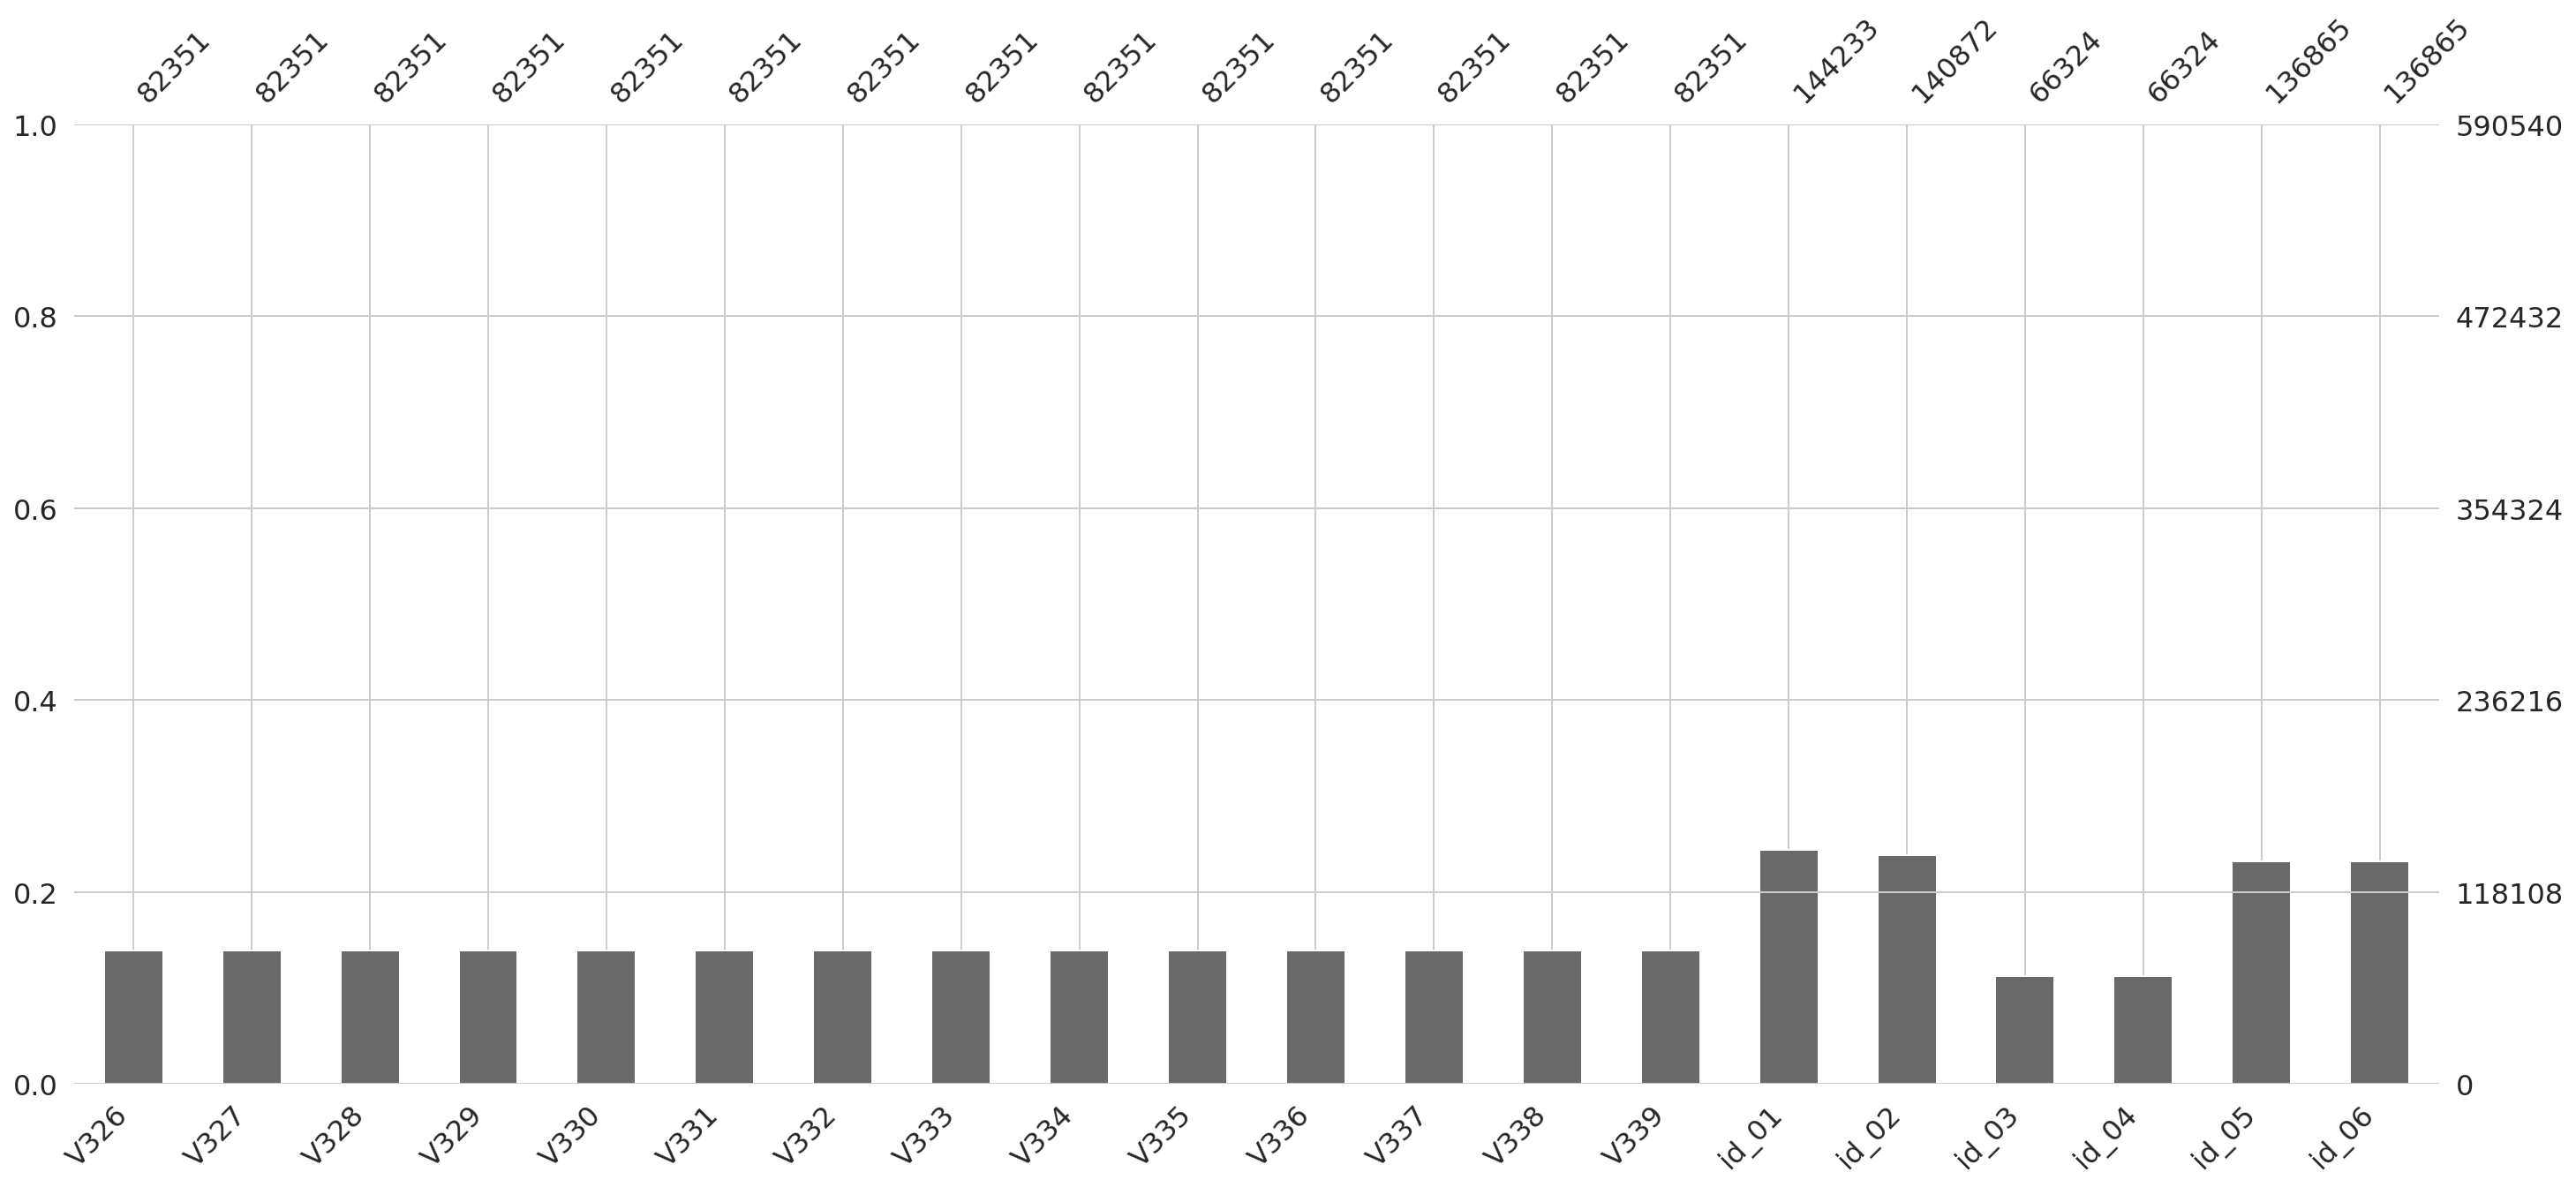

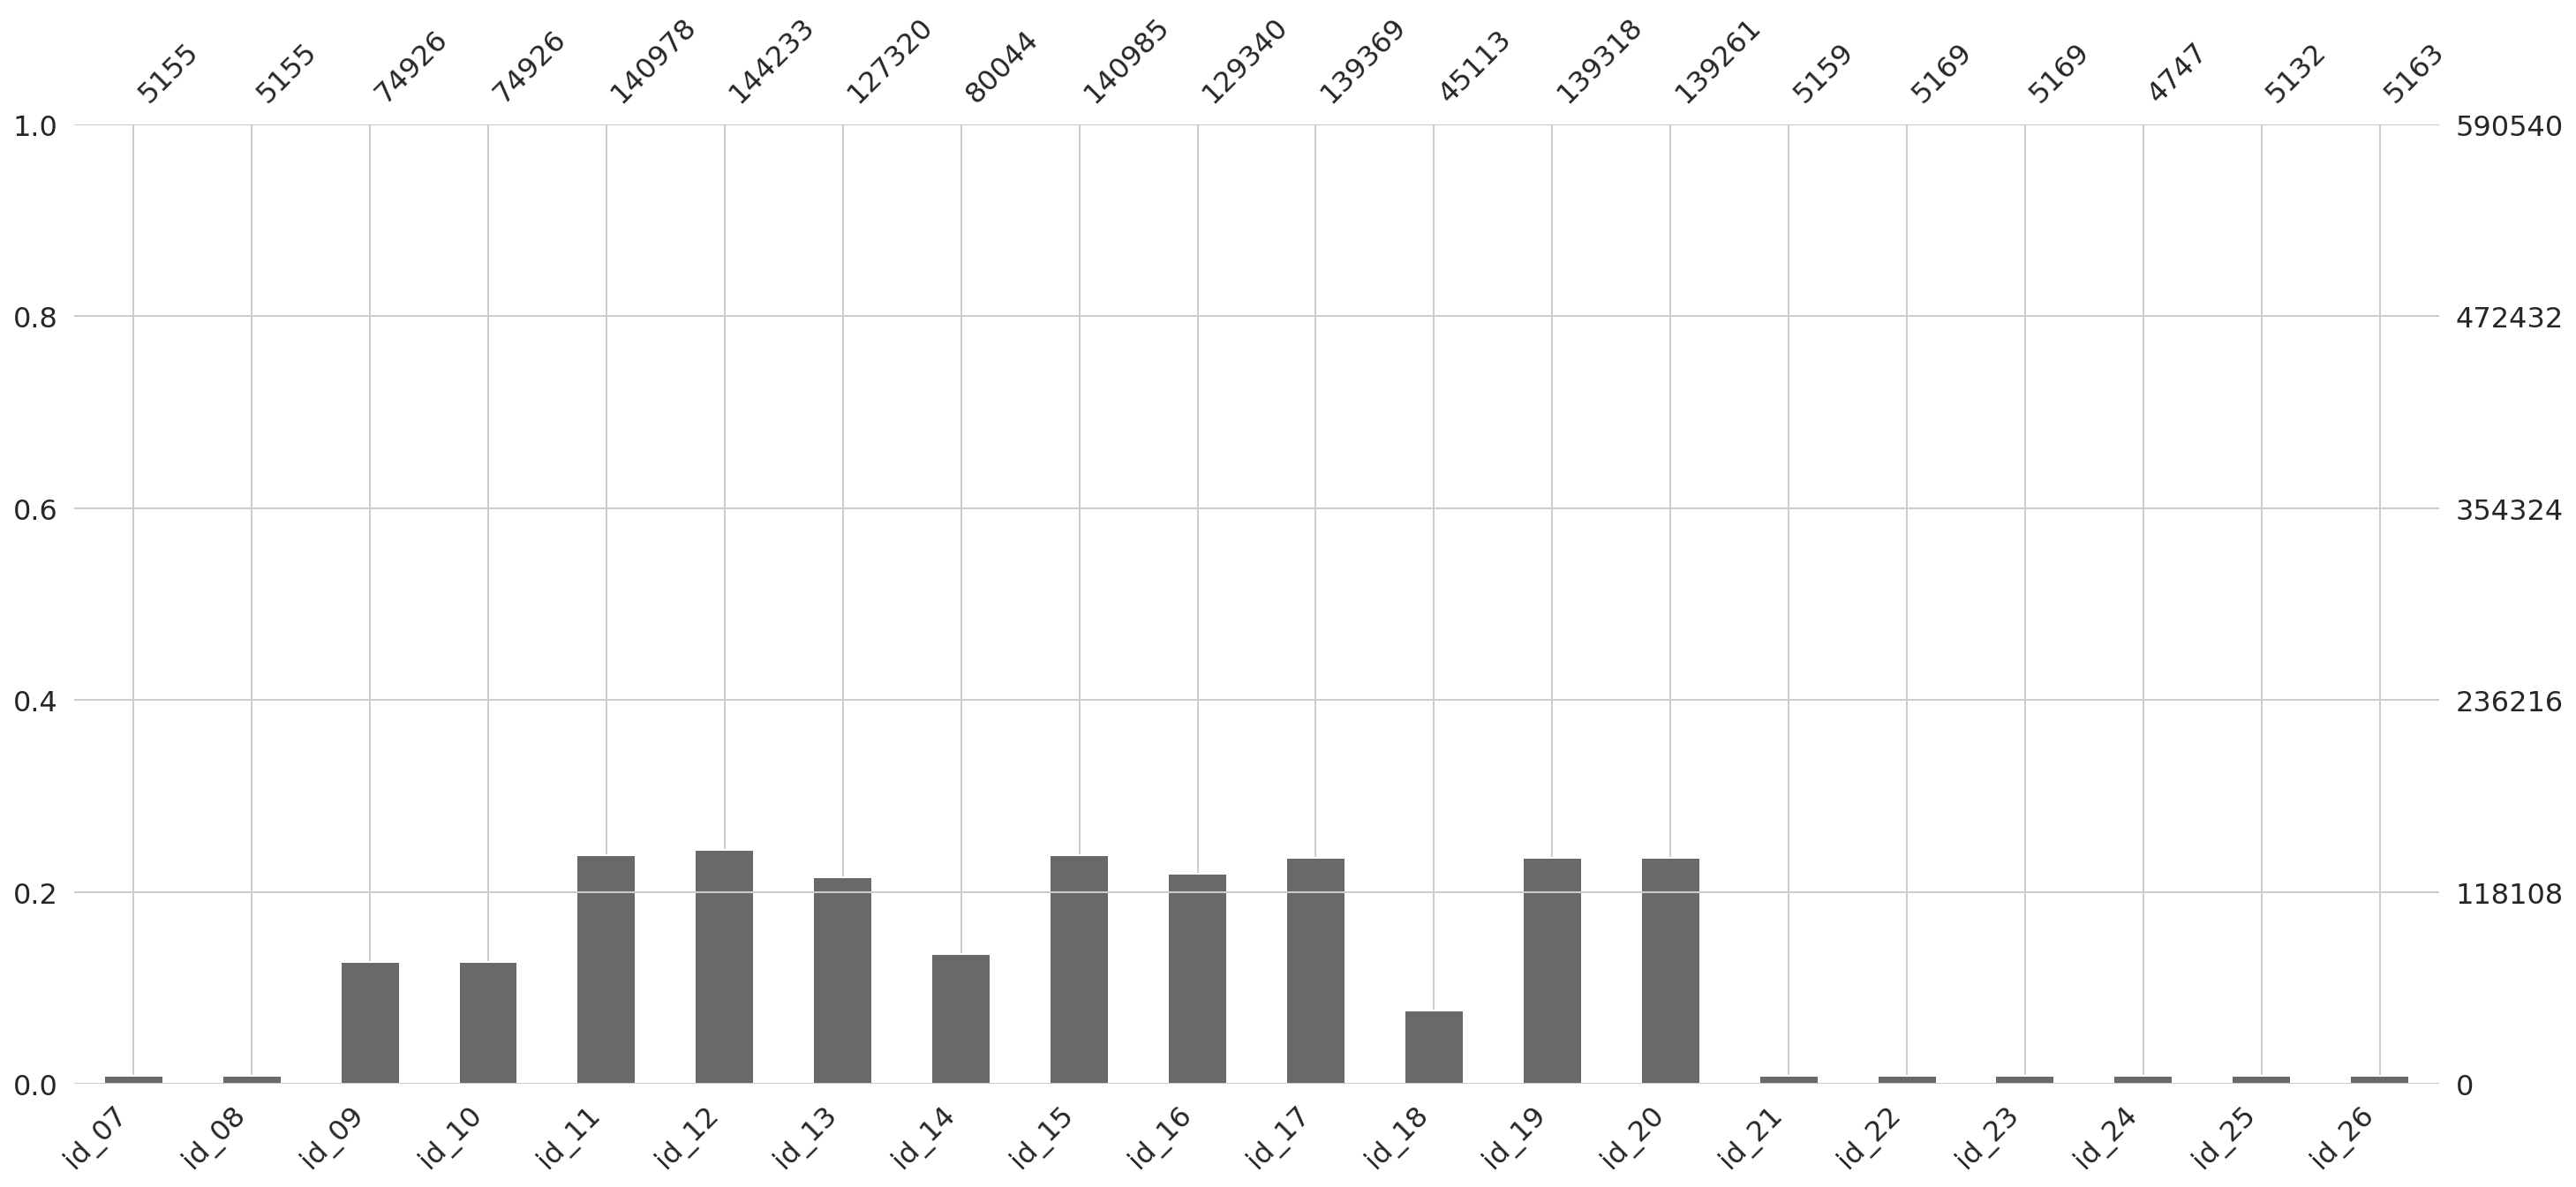

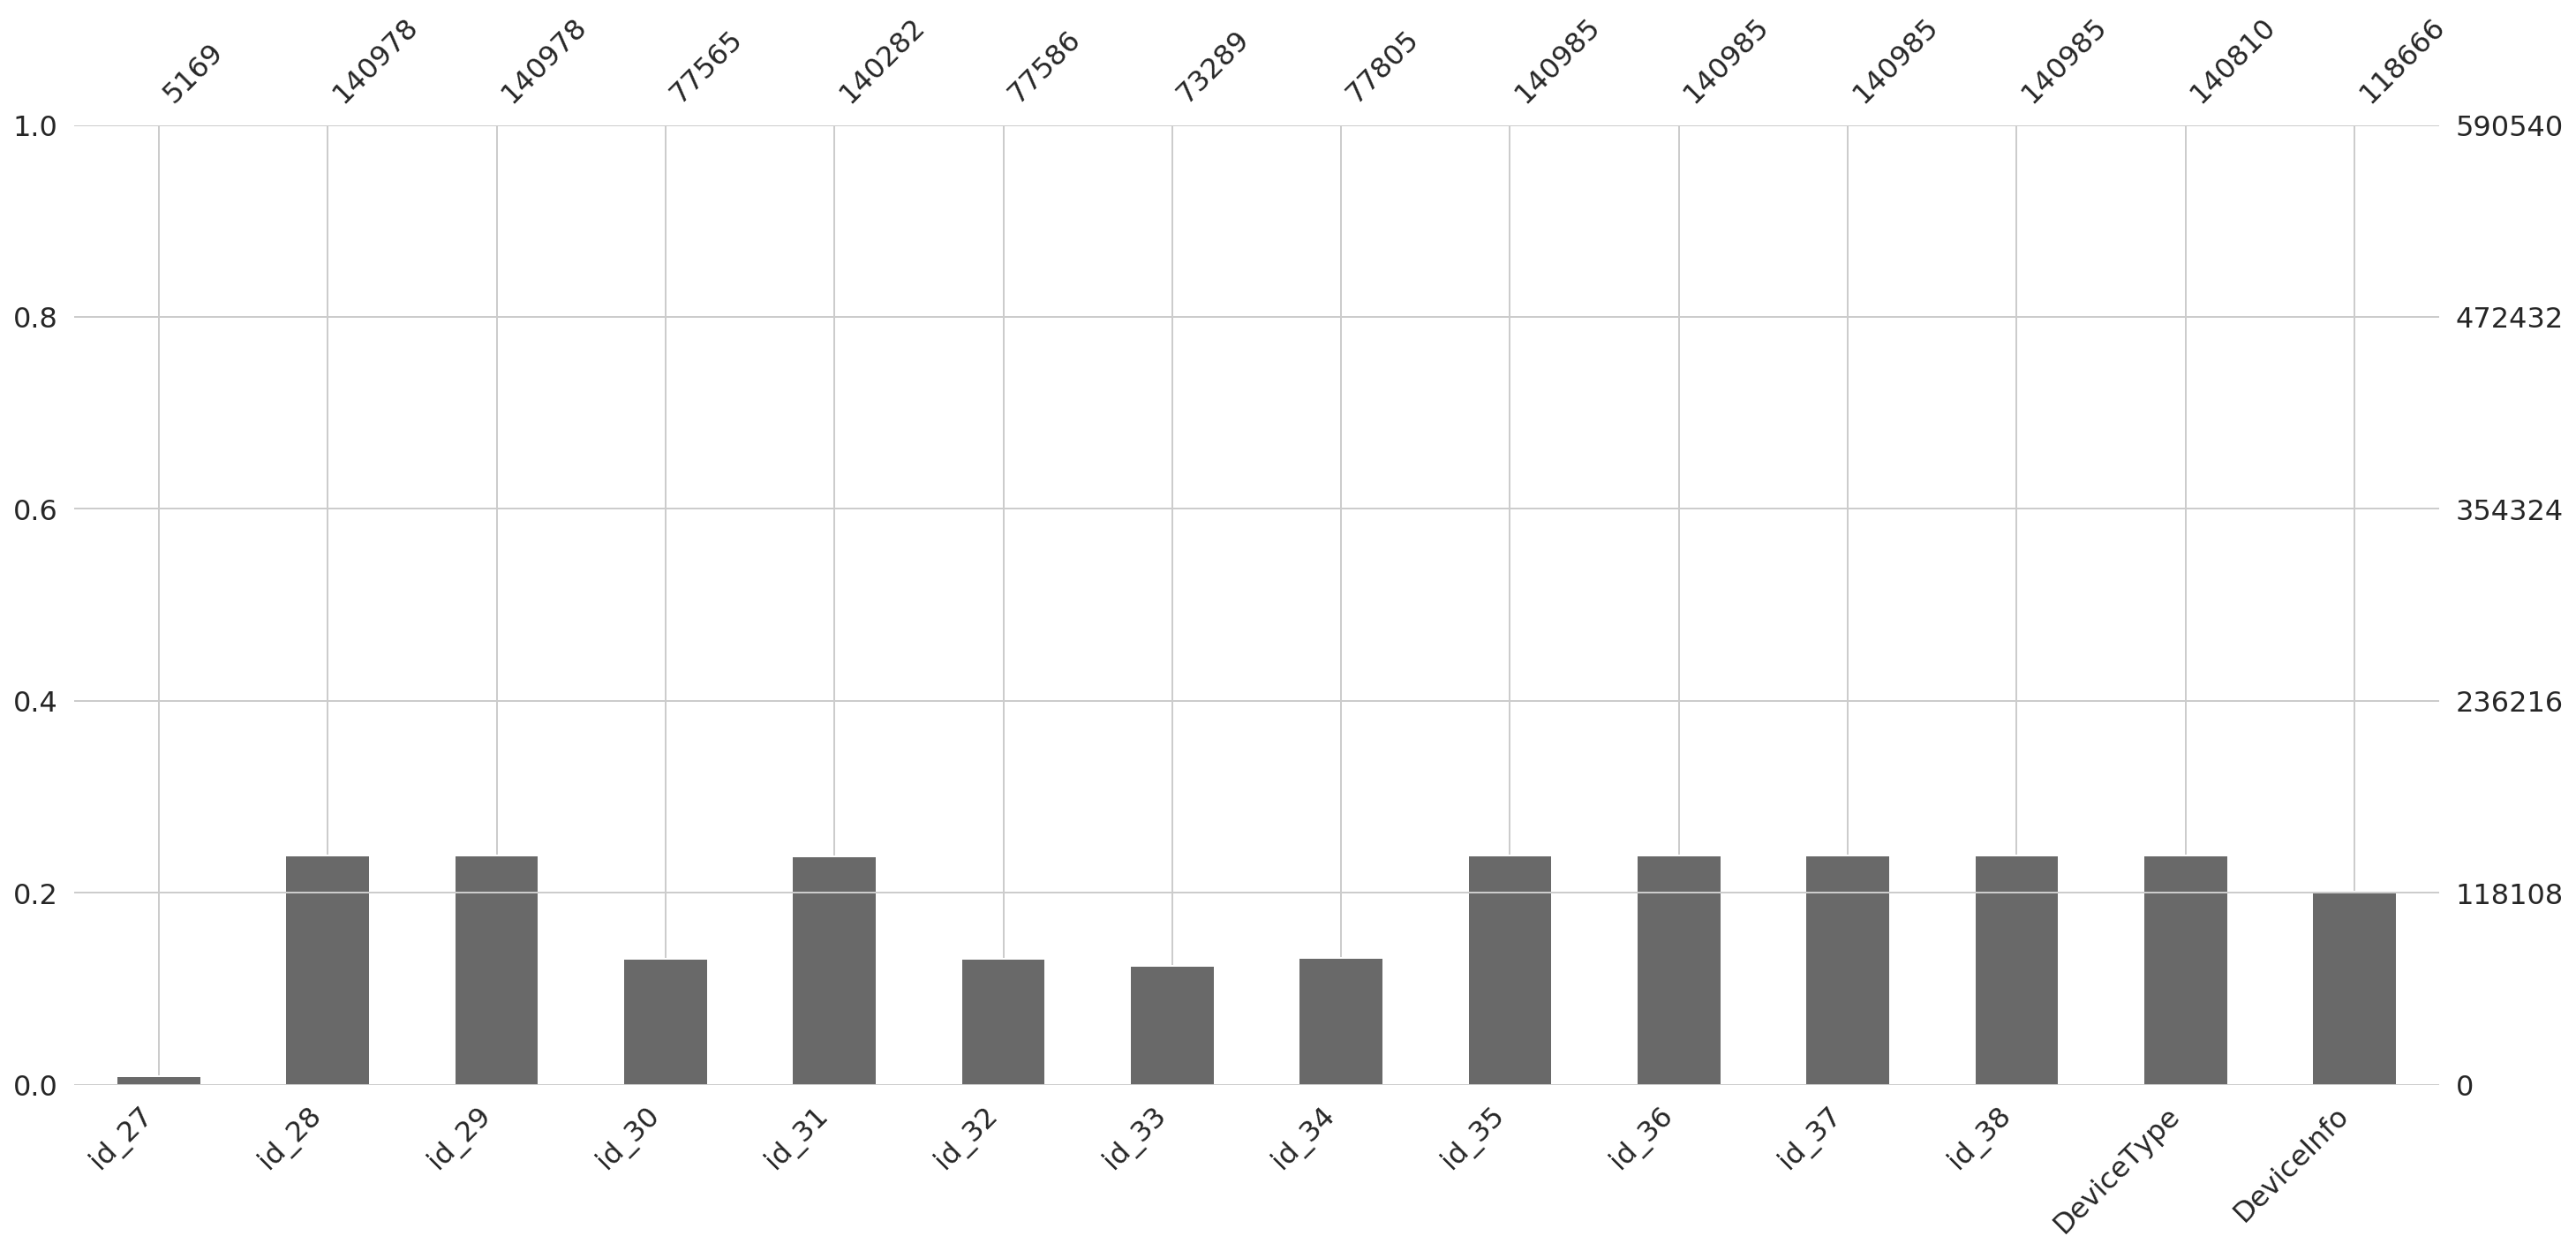

In [12]:
def list_chunks(initial_list, size: int = 20):
    """
    Generator for list chunks with equal size.
    
    :param initial_list: list to be divided into chunks.
    :param size: maximum size of each chunk.
    :yield: list chunk of maximum size `size`.
    """
    for x in range(0, len(initial_list), size):
        yield initial_list[x:x + size]


for columns in list_chunks(df.columns):
    msno.bar(df[columns])
    plt.show()

We can see that there are a lot of atributes with so many missing values (in some attributes, more that 50% are missing values). Those attributes should be dropped in preprocessing phase, or representative value should be filled in.

Because our method is based on using nature inspired algorithms for feature selection, maybe also attributes with majority of missing values will be used in modeling phase.

### Attributes analysis

# TODO

- graphs for each attribute?
- categorical variables histograms per class

### Conclusion

In this jupyter notebook, we have looked at the data and checked characteristics of attributes. During data analysis, we have found some problems with data (a lot of missing values, incorrect data types, imbalanced classes) that have to be figured out in preprocessing phase. The data analysis also gave us a picture about what attributes are available and which and how can be used for prediction.